# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper


helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

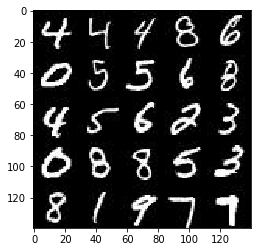

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

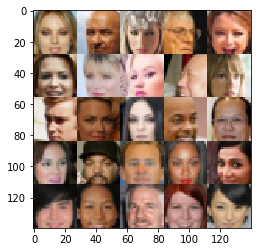

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    lr = tf.placeholder(tf.float32, (None), name='learning_rate')

    return real_input, z_input, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def leaky_relu(x, alpha=0.2, name='leaky_relu'):
    return tf.maximum(alpha*x, x, name=name)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        
        # This is a normal convnet classifier, 
        # the input images are either 28x28x1 (mnist) or 28x28x3 (faces)
        # and the output is a boolean
        # (because it is trying to decide between true and fake images)
        
        # For Downsampling, replace pooling layers with strided convolutions.
        
        # conv 1
        conv1 = tf.layers.conv2d(images, filters=64, kernel_size=(5, 5), strides=(2, 2), 
                                 padding='same', activation=None, 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = leaky_relu(conv1)
        # Using dropout in the discriminator makes it less prone to 
        # mistakes the generator can exploit instead of learning the data distribution.
        relu1 =  tf.nn.dropout(relu1, keep_prob=0.7)
        # now 14x14x...
        
        # conv 2
        conv2 = tf.layers.conv2d(relu1, filters=128, kernel_size=(5, 5), strides=(2, 2), 
                                 padding='same', activation=None, 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = leaky_relu(bn2)
        relu2 =  tf.nn.dropout(relu2, keep_prob=0.75)
        # now 7x7x...

        
        # Output layer
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(inputs=flat, units=1)
        
        out = tf.sigmoid(logits)
        
        # the output of the activation (out) is used in the discriminator loss, to train the discriminator
        # the logits are used to train the Generator coefficients
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    # the generator is called in training mode, but also sampled during training,
    # the only time the generator weights need to be reused is during sampling
    # not during training (reuse is True only when is_train is False)
    with tf.variable_scope('generator', reuse = not is_train):
        
        # First fully connected layer
        # 1x100 to 7x7x...
        # first transform into a flat 1-D array that is easy to reshape
        x1_units = 512
        x1 = tf.layers.dense(inputs=z, units=7*7*x1_units, activation=None, 
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        # then reshape into the reqired dimension of (None, 7, 7, 512)
        # with the added dimension for batching, it must be in batch format
        # to call batch normalization
        x1 = tf.reshape(x1, (-1, 7, 7, x1_units))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # now 7x7x...
        
        # Deconvolution (tecnically incorrect name)
        # Replace any pooling layers with fractional-strided convolutions.
        # (xavier_initializer_conv2d = xavier_initializer)
        x2 = tf.layers.conv2d_transpose(x1, filters=128, kernel_size=(5, 5), strides=(2, 2), 
                                        padding='same', activation=None, 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        x2 =  tf.nn.dropout(x2, keep_prob=0.5)
        # now 14x14x...
        
        # Fractional-strided convolution
        x4 = tf.layers.conv2d_transpose(x2, filters=16, kernel_size=(5, 5), strides=(2, 2), 
                                        padding='same', activation=None, 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = leaky_relu(x4)
        x4 =  tf.nn.dropout(x4, keep_prob=0.5)
        # now 28x28x..
        
        # Fractional-strided convolution 
        logits = tf.layers.conv2d_transpose(x4, filters=out_channel_dim, kernel_size=(1, 1), strides=(1, 1), 
                                            padding='same', activation=None, 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        # Now 28x28x3 or 28x28x1 (output layer)
        
        out = tf.tanh(logits)

        
        # returns the activation (no need to return logits from the generator)
        return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # 1. Build the GAN

    # Create the computational graph of the Generator (g_model):
    # The generator will take as input a vector input_z 
    # and output a tensor that is the same size as the real images (input_size)
    g_model = generator(input_z, out_channel_dim, is_train=True)


    # Discriminator: 2 instances, the first process the actual image
    # the 2nd instance process the fake image with the same weights (reuse)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    
    # 2. Compute Losses
    
    # one-sided label smoothing
    smooth = 0.1
    d_labels_real = tf.ones_like(d_logits_real) * (1-smooth)
    
    # Discriminator loss:
    # takes logits of the real images and labels of ones,
    # this part of the loss function teaches the discriminator 
    # to label real images with 1's
    d_loss_real = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                            labels=d_labels_real))

    # takes the logits of the fake inputs and labels of zeros
    # these are the negative examples to train the discriminator
    d_labels_fake = tf.zeros_like(d_logits_fake)
    d_loss_fake = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                            labels=d_labels_fake))

    d_loss = d_loss_real + d_loss_fake


    # Generator loss:
    # takes the *discriminator* logits of the fake inputs and the labels are 1's (this tells 
    # the generator that the output of the discriminator should be 1's)
    # so the whole discriminator network becomes the first part of the loss function
    # of the generator network; the second part is the cross entropy, which 
    # function that corrects the problem of zero-gradients that the sigmoid function has.
    g_labels = tf.ones_like(d_logits_fake) 
    g_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                        labels=g_labels))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    # Optimizers

    # Get the trainable_variables for the Generator and Discriminator networds separately
    t_vars = tf.trainable_variables()
    g_vars = [t_var for t_var in t_vars if t_var.name.startswith('generator')]
    d_vars = [t_var for t_var in t_vars if t_var.name.startswith('discriminator')]

    # run the Optimizers
    # making sure to execute the update ops in the computational graph 
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_training_loss(losses):
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Training Losses")
    plt.legend()


def train(epoch_count, batch_size, z_dim, 
          learning_rate, beta1, 
          get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L") - for showGeneratorOutput()
    """
    print(data_shape)
    image_width, image_height, image_channels = data_shape[1:]
    
    # 1. Build the Computational Graph  (pre-execution): 
    # 1.1 return some placeholders which need to be filled in the sess.run() !
    real_input, z_input, lr = model_inputs(image_width, image_height, image_channels, z_dim)  
    
    # 1.2 get the computational graphs of the two networks
    d_loss, g_loss = model_loss(real_input, z_input, image_channels)

    # 1.3 compose the networks with the optimizers
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)    
    
    
    # 2. Execution
    losses = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1
                # get_batches already scales the images to a range [-.5, .5] 
                # rescale the images to a range of -1 to 1, to make it comparable
                # with the output of our generator which is a tanh.
                batch_images = batch_images*2

                # Prior Distribution
                # Sample random noise for G
                # the input_z vector is the value for the z_input placeholder
                # it doesn't need to be scaled in the range [-1, 1], because
                # it isn't compared to an image.
                input_z = np.random.normal(0, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={real_input: batch_images, 
                                                     z_input: input_z, 
                                                     lr: learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={real_input: batch_images, 
                                                     z_input: input_z, 
                                                     lr: learning_rate})
                
                
                # ------------------------------------------------------------
                if steps % 20 == 0:
                    # compute the losses and print them out  
                    train_loss_d = d_loss.eval({real_input: batch_images, z_input: input_z})
                    train_loss_g = g_loss.eval({real_input: batch_images, z_input: input_z})

                    print("Epoch {}/{}    Batch {}...".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, z_input, image_channels, data_image_mode)

    plot_training_loss(losses)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/2    Batch 20... Discriminator Loss: 1.2748... Generator Loss: 2.1061
Epoch 1/2    Batch 40... Discriminator Loss: 1.4294... Generator Loss: 0.5486
Epoch 1/2    Batch 60... Discriminator Loss: 1.1960... Generator Loss: 0.8247
Epoch 1/2    Batch 80... Discriminator Loss: 1.6002... Generator Loss: 0.5512
Epoch 1/2    Batch 100... Discriminator Loss: 1.2964... Generator Loss: 1.0152


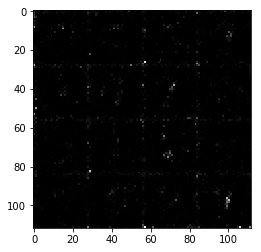

Epoch 1/2    Batch 120... Discriminator Loss: 1.1574... Generator Loss: 0.9698
Epoch 1/2    Batch 140... Discriminator Loss: 1.0599... Generator Loss: 1.3566
Epoch 1/2    Batch 160... Discriminator Loss: 0.9108... Generator Loss: 1.8842
Epoch 1/2    Batch 180... Discriminator Loss: 1.1267... Generator Loss: 1.2210
Epoch 1/2    Batch 200... Discriminator Loss: 0.9764... Generator Loss: 1.3369


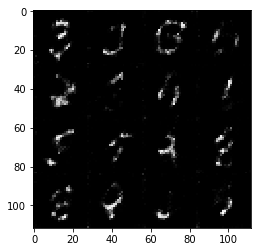

Epoch 1/2    Batch 220... Discriminator Loss: 1.4037... Generator Loss: 0.6374
Epoch 1/2    Batch 240... Discriminator Loss: 1.0677... Generator Loss: 1.4488
Epoch 1/2    Batch 260... Discriminator Loss: 1.0124... Generator Loss: 1.3849
Epoch 1/2    Batch 280... Discriminator Loss: 1.5531... Generator Loss: 0.3590
Epoch 1/2    Batch 300... Discriminator Loss: 1.1318... Generator Loss: 1.1515


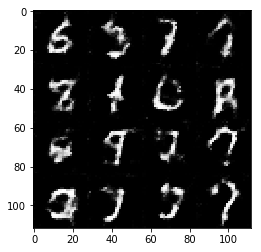

Epoch 1/2    Batch 320... Discriminator Loss: 1.1484... Generator Loss: 1.8244
Epoch 1/2    Batch 340... Discriminator Loss: 1.5027... Generator Loss: 2.2733
Epoch 1/2    Batch 360... Discriminator Loss: 1.0831... Generator Loss: 1.1573
Epoch 1/2    Batch 380... Discriminator Loss: 1.2253... Generator Loss: 1.4062
Epoch 1/2    Batch 400... Discriminator Loss: 1.2470... Generator Loss: 1.6945


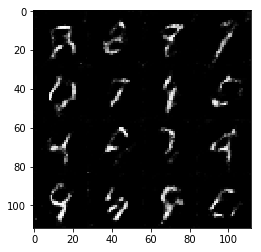

Epoch 1/2    Batch 420... Discriminator Loss: 1.2815... Generator Loss: 1.5436
Epoch 1/2    Batch 440... Discriminator Loss: 1.2682... Generator Loss: 1.0392
Epoch 1/2    Batch 460... Discriminator Loss: 1.2597... Generator Loss: 0.9365
Epoch 1/2    Batch 480... Discriminator Loss: 1.3899... Generator Loss: 1.1666
Epoch 1/2    Batch 500... Discriminator Loss: 1.2092... Generator Loss: 0.9777


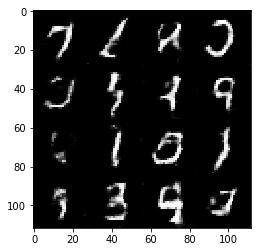

Epoch 1/2    Batch 520... Discriminator Loss: 1.3162... Generator Loss: 0.8619
Epoch 1/2    Batch 540... Discriminator Loss: 1.1023... Generator Loss: 1.0859
Epoch 1/2    Batch 560... Discriminator Loss: 1.2159... Generator Loss: 0.9278
Epoch 1/2    Batch 580... Discriminator Loss: 1.3532... Generator Loss: 1.2819
Epoch 1/2    Batch 600... Discriminator Loss: 1.1978... Generator Loss: 1.5631


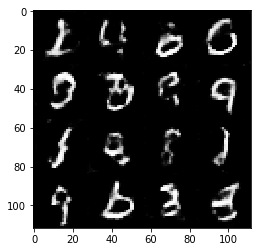

Epoch 1/2    Batch 620... Discriminator Loss: 1.3337... Generator Loss: 0.7312
Epoch 1/2    Batch 640... Discriminator Loss: 1.1437... Generator Loss: 1.1293
Epoch 1/2    Batch 660... Discriminator Loss: 1.1756... Generator Loss: 1.3680
Epoch 1/2    Batch 680... Discriminator Loss: 1.0289... Generator Loss: 1.3075
Epoch 1/2    Batch 700... Discriminator Loss: 1.2203... Generator Loss: 0.6720


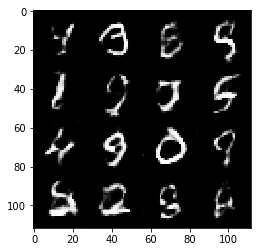

Epoch 1/2    Batch 720... Discriminator Loss: 1.3623... Generator Loss: 0.8192
Epoch 1/2    Batch 740... Discriminator Loss: 1.1497... Generator Loss: 1.0418
Epoch 1/2    Batch 760... Discriminator Loss: 1.1943... Generator Loss: 0.9215
Epoch 1/2    Batch 780... Discriminator Loss: 1.1629... Generator Loss: 1.0252
Epoch 1/2    Batch 800... Discriminator Loss: 1.0753... Generator Loss: 1.1999


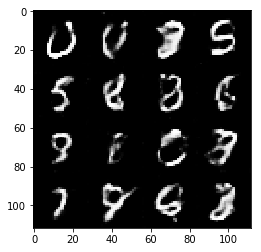

Epoch 1/2    Batch 820... Discriminator Loss: 1.2842... Generator Loss: 1.0469
Epoch 1/2    Batch 840... Discriminator Loss: 1.3502... Generator Loss: 0.5908
Epoch 1/2    Batch 860... Discriminator Loss: 1.4661... Generator Loss: 0.8637
Epoch 1/2    Batch 880... Discriminator Loss: 1.1750... Generator Loss: 0.9179
Epoch 1/2    Batch 900... Discriminator Loss: 1.2016... Generator Loss: 0.8170


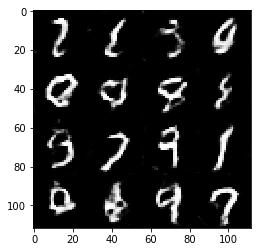

Epoch 1/2    Batch 920... Discriminator Loss: 1.2306... Generator Loss: 0.9398
Epoch 2/2    Batch 20... Discriminator Loss: 1.2784... Generator Loss: 1.3343
Epoch 2/2    Batch 40... Discriminator Loss: 1.4343... Generator Loss: 0.6675
Epoch 2/2    Batch 60... Discriminator Loss: 1.0981... Generator Loss: 1.1183
Epoch 2/2    Batch 80... Discriminator Loss: 1.4004... Generator Loss: 0.6075
Epoch 2/2    Batch 100... Discriminator Loss: 1.2825... Generator Loss: 1.1891


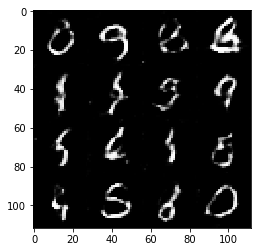

Epoch 2/2    Batch 120... Discriminator Loss: 1.5551... Generator Loss: 0.4693
Epoch 2/2    Batch 140... Discriminator Loss: 1.1470... Generator Loss: 1.4127
Epoch 2/2    Batch 160... Discriminator Loss: 1.1589... Generator Loss: 0.8828
Epoch 2/2    Batch 180... Discriminator Loss: 1.2036... Generator Loss: 0.9985
Epoch 2/2    Batch 200... Discriminator Loss: 1.2949... Generator Loss: 1.9853


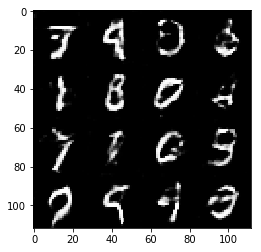

Epoch 2/2    Batch 220... Discriminator Loss: 1.1554... Generator Loss: 2.0634
Epoch 2/2    Batch 240... Discriminator Loss: 1.1620... Generator Loss: 1.3752
Epoch 2/2    Batch 260... Discriminator Loss: 1.0872... Generator Loss: 0.8440
Epoch 2/2    Batch 280... Discriminator Loss: 1.1745... Generator Loss: 1.3900
Epoch 2/2    Batch 300... Discriminator Loss: 1.0385... Generator Loss: 1.0513


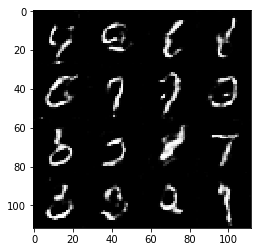

Epoch 2/2    Batch 320... Discriminator Loss: 1.0449... Generator Loss: 1.1102
Epoch 2/2    Batch 340... Discriminator Loss: 1.4066... Generator Loss: 2.2608
Epoch 2/2    Batch 360... Discriminator Loss: 1.0430... Generator Loss: 1.6091
Epoch 2/2    Batch 380... Discriminator Loss: 1.0596... Generator Loss: 1.3540
Epoch 2/2    Batch 400... Discriminator Loss: 1.2551... Generator Loss: 1.7776


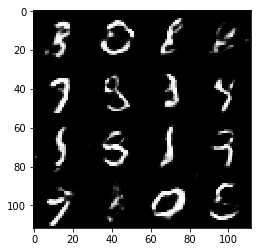

Epoch 2/2    Batch 420... Discriminator Loss: 1.0692... Generator Loss: 1.0981
Epoch 2/2    Batch 440... Discriminator Loss: 1.0545... Generator Loss: 1.1429
Epoch 2/2    Batch 460... Discriminator Loss: 1.1107... Generator Loss: 0.7822
Epoch 2/2    Batch 480... Discriminator Loss: 1.2231... Generator Loss: 1.2934
Epoch 2/2    Batch 500... Discriminator Loss: 1.1372... Generator Loss: 1.2789


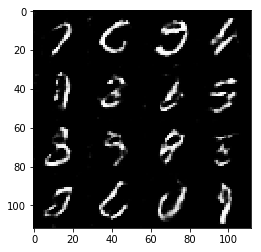

Epoch 2/2    Batch 520... Discriminator Loss: 1.0914... Generator Loss: 1.1312
Epoch 2/2    Batch 540... Discriminator Loss: 0.9834... Generator Loss: 1.1134
Epoch 2/2    Batch 560... Discriminator Loss: 1.0900... Generator Loss: 1.0753
Epoch 2/2    Batch 580... Discriminator Loss: 1.1656... Generator Loss: 1.3902
Epoch 2/2    Batch 600... Discriminator Loss: 1.0007... Generator Loss: 1.1814


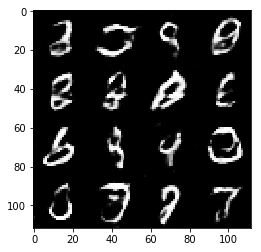

Epoch 2/2    Batch 620... Discriminator Loss: 1.1213... Generator Loss: 1.4899
Epoch 2/2    Batch 640... Discriminator Loss: 1.1249... Generator Loss: 0.9721
Epoch 2/2    Batch 660... Discriminator Loss: 1.0935... Generator Loss: 1.1238
Epoch 2/2    Batch 680... Discriminator Loss: 1.0672... Generator Loss: 0.8389
Epoch 2/2    Batch 700... Discriminator Loss: 1.1558... Generator Loss: 1.1414


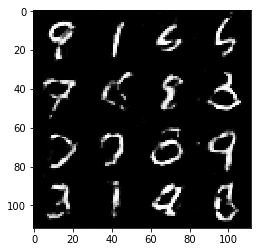

Epoch 2/2    Batch 720... Discriminator Loss: 1.0079... Generator Loss: 1.1799
Epoch 2/2    Batch 740... Discriminator Loss: 1.3262... Generator Loss: 0.8258
Epoch 2/2    Batch 760... Discriminator Loss: 1.0662... Generator Loss: 1.4365
Epoch 2/2    Batch 780... Discriminator Loss: 1.2178... Generator Loss: 0.6849
Epoch 2/2    Batch 800... Discriminator Loss: 1.1942... Generator Loss: 0.9100


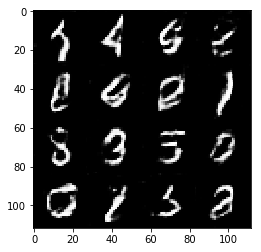

Epoch 2/2    Batch 820... Discriminator Loss: 1.1685... Generator Loss: 1.4321
Epoch 2/2    Batch 840... Discriminator Loss: 1.1297... Generator Loss: 1.8319
Epoch 2/2    Batch 860... Discriminator Loss: 1.2638... Generator Loss: 0.7808
Epoch 2/2    Batch 880... Discriminator Loss: 1.0422... Generator Loss: 1.7145
Epoch 2/2    Batch 900... Discriminator Loss: 1.1506... Generator Loss: 1.6438


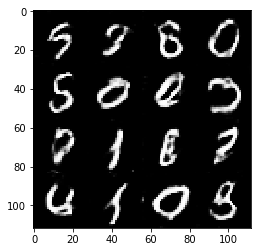

Epoch 2/2    Batch 920... Discriminator Loss: 1.2493... Generator Loss: 0.8148


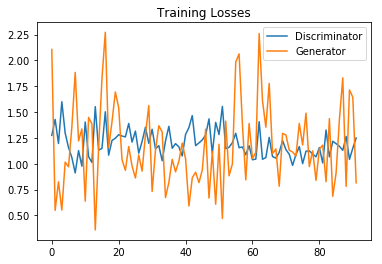

In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch 1/1    Batch 20... Discriminator Loss: 0.7466... Generator Loss: 2.1586
Epoch 1/1    Batch 40... Discriminator Loss: 0.5543... Generator Loss: 2.4425
Epoch 1/1    Batch 60... Discriminator Loss: 0.5776... Generator Loss: 2.3346
Epoch 1/1    Batch 80... Discriminator Loss: 0.5098... Generator Loss: 3.1902
Epoch 1/1    Batch 100... Discriminator Loss: 0.6476... Generator Loss: 2.7153


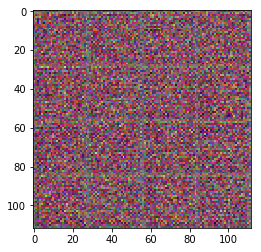

Epoch 1/1    Batch 120... Discriminator Loss: 0.4420... Generator Loss: 2.9312
Epoch 1/1    Batch 140... Discriminator Loss: 0.4826... Generator Loss: 3.0316
Epoch 1/1    Batch 160... Discriminator Loss: 0.5135... Generator Loss: 3.3249
Epoch 1/1    Batch 180... Discriminator Loss: 0.5079... Generator Loss: 2.7931
Epoch 1/1    Batch 200... Discriminator Loss: 0.4562... Generator Loss: 2.9328


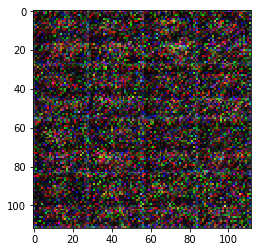

Epoch 1/1    Batch 220... Discriminator Loss: 0.5662... Generator Loss: 2.9658
Epoch 1/1    Batch 240... Discriminator Loss: 0.4979... Generator Loss: 3.2189
Epoch 1/1    Batch 260... Discriminator Loss: 0.4745... Generator Loss: 3.0343
Epoch 1/1    Batch 280... Discriminator Loss: 0.4340... Generator Loss: 3.0007
Epoch 1/1    Batch 300... Discriminator Loss: 0.4695... Generator Loss: 3.1671


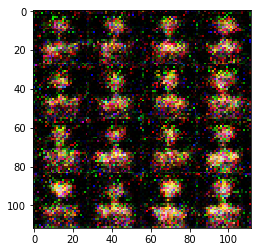

Epoch 1/1    Batch 320... Discriminator Loss: 0.4233... Generator Loss: 3.3139
Epoch 1/1    Batch 340... Discriminator Loss: 0.4084... Generator Loss: 3.9687
Epoch 1/1    Batch 360... Discriminator Loss: 0.4164... Generator Loss: 3.8682
Epoch 1/1    Batch 380... Discriminator Loss: 0.4113... Generator Loss: 3.6583
Epoch 1/1    Batch 400... Discriminator Loss: 0.4234... Generator Loss: 3.5999


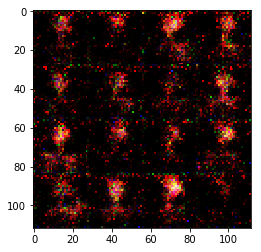

Epoch 1/1    Batch 420... Discriminator Loss: 0.4869... Generator Loss: 3.8964
Epoch 1/1    Batch 440... Discriminator Loss: 0.3891... Generator Loss: 4.1352
Epoch 1/1    Batch 460... Discriminator Loss: 0.4191... Generator Loss: 3.7297
Epoch 1/1    Batch 480... Discriminator Loss: 0.4789... Generator Loss: 3.3304
Epoch 1/1    Batch 500... Discriminator Loss: 0.4378... Generator Loss: 3.8782


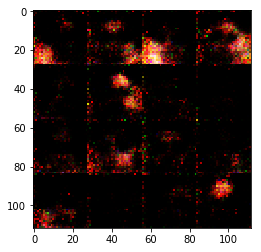

Epoch 1/1    Batch 520... Discriminator Loss: 0.4166... Generator Loss: 3.6190
Epoch 1/1    Batch 540... Discriminator Loss: 0.3934... Generator Loss: 3.8197
Epoch 1/1    Batch 560... Discriminator Loss: 0.5176... Generator Loss: 2.4756
Epoch 1/1    Batch 580... Discriminator Loss: 0.4681... Generator Loss: 2.3840
Epoch 1/1    Batch 600... Discriminator Loss: 0.3728... Generator Loss: 3.5820


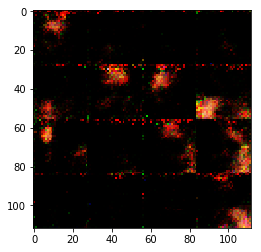

Epoch 1/1    Batch 620... Discriminator Loss: 0.4141... Generator Loss: 3.5585
Epoch 1/1    Batch 640... Discriminator Loss: 0.3956... Generator Loss: 3.7553
Epoch 1/1    Batch 660... Discriminator Loss: 0.4319... Generator Loss: 3.3493
Epoch 1/1    Batch 680... Discriminator Loss: 0.4462... Generator Loss: 3.3108
Epoch 1/1    Batch 700... Discriminator Loss: 0.4409... Generator Loss: 2.8861


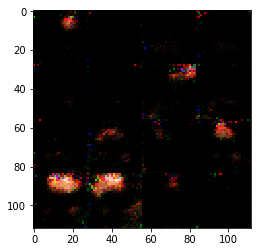

Epoch 1/1    Batch 720... Discriminator Loss: 0.4153... Generator Loss: 3.4607
Epoch 1/1    Batch 740... Discriminator Loss: 0.3794... Generator Loss: 3.7384
Epoch 1/1    Batch 760... Discriminator Loss: 0.4018... Generator Loss: 3.6611
Epoch 1/1    Batch 780... Discriminator Loss: 0.4045... Generator Loss: 3.5868
Epoch 1/1    Batch 800... Discriminator Loss: 0.3973... Generator Loss: 4.7456


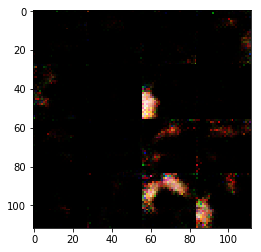

Epoch 1/1    Batch 820... Discriminator Loss: 0.3838... Generator Loss: 4.1238
Epoch 1/1    Batch 840... Discriminator Loss: 0.4271... Generator Loss: 3.4782
Epoch 1/1    Batch 860... Discriminator Loss: 0.5529... Generator Loss: 2.4980
Epoch 1/1    Batch 880... Discriminator Loss: 0.3910... Generator Loss: 3.6597
Epoch 1/1    Batch 900... Discriminator Loss: 0.4450... Generator Loss: 3.2257


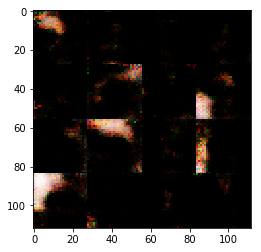

Epoch 1/1    Batch 920... Discriminator Loss: 0.4070... Generator Loss: 3.8270
Epoch 1/1    Batch 940... Discriminator Loss: 0.4758... Generator Loss: 2.3066
Epoch 1/1    Batch 960... Discriminator Loss: 0.3711... Generator Loss: 4.5163
Epoch 1/1    Batch 980... Discriminator Loss: 0.3752... Generator Loss: 4.3303
Epoch 1/1    Batch 1000... Discriminator Loss: 0.4910... Generator Loss: 2.2020


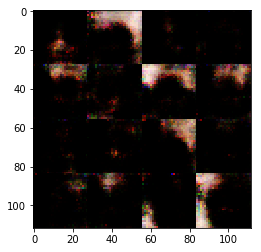

Epoch 1/1    Batch 1020... Discriminator Loss: 0.4224... Generator Loss: 3.5758
Epoch 1/1    Batch 1040... Discriminator Loss: 0.4175... Generator Loss: 3.8824
Epoch 1/1    Batch 1060... Discriminator Loss: 0.4491... Generator Loss: 3.1784
Epoch 1/1    Batch 1080... Discriminator Loss: 0.4342... Generator Loss: 2.9211
Epoch 1/1    Batch 1100... Discriminator Loss: 0.5023... Generator Loss: 2.8902


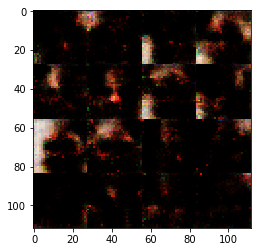

Epoch 1/1    Batch 1120... Discriminator Loss: 0.4715... Generator Loss: 2.4651
Epoch 1/1    Batch 1140... Discriminator Loss: 0.5450... Generator Loss: 2.4817
Epoch 1/1    Batch 1160... Discriminator Loss: 0.4893... Generator Loss: 2.6680
Epoch 1/1    Batch 1180... Discriminator Loss: 0.5305... Generator Loss: 1.9841
Epoch 1/1    Batch 1200... Discriminator Loss: 0.5468... Generator Loss: 2.1814


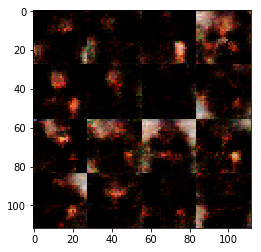

Epoch 1/1    Batch 1220... Discriminator Loss: 0.6661... Generator Loss: 1.4143
Epoch 1/1    Batch 1240... Discriminator Loss: 0.4245... Generator Loss: 2.5219
Epoch 1/1    Batch 1260... Discriminator Loss: 0.5677... Generator Loss: 2.0670
Epoch 1/1    Batch 1280... Discriminator Loss: 0.6116... Generator Loss: 2.1195
Epoch 1/1    Batch 1300... Discriminator Loss: 0.6148... Generator Loss: 2.0611


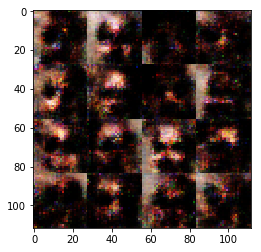

Epoch 1/1    Batch 1320... Discriminator Loss: 0.5083... Generator Loss: 2.9034
Epoch 1/1    Batch 1340... Discriminator Loss: 0.6769... Generator Loss: 2.5269
Epoch 1/1    Batch 1360... Discriminator Loss: 0.6990... Generator Loss: 2.0613
Epoch 1/1    Batch 1380... Discriminator Loss: 0.7274... Generator Loss: 2.0733
Epoch 1/1    Batch 1400... Discriminator Loss: 0.5785... Generator Loss: 2.0041


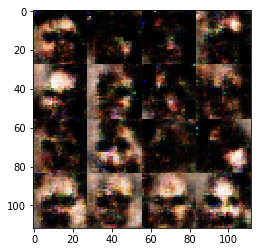

Epoch 1/1    Batch 1420... Discriminator Loss: 0.5544... Generator Loss: 3.0710
Epoch 1/1    Batch 1440... Discriminator Loss: 0.5778... Generator Loss: 2.2042
Epoch 1/1    Batch 1460... Discriminator Loss: 0.6069... Generator Loss: 1.9691
Epoch 1/1    Batch 1480... Discriminator Loss: 0.5250... Generator Loss: 2.5273
Epoch 1/1    Batch 1500... Discriminator Loss: 0.5715... Generator Loss: 2.6044


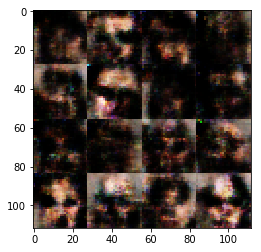

Epoch 1/1    Batch 1520... Discriminator Loss: 0.7451... Generator Loss: 2.2156
Epoch 1/1    Batch 1540... Discriminator Loss: 0.6651... Generator Loss: 2.1152
Epoch 1/1    Batch 1560... Discriminator Loss: 0.6097... Generator Loss: 2.5174
Epoch 1/1    Batch 1580... Discriminator Loss: 0.7777... Generator Loss: 2.1218
Epoch 1/1    Batch 1600... Discriminator Loss: 0.6308... Generator Loss: 2.3047


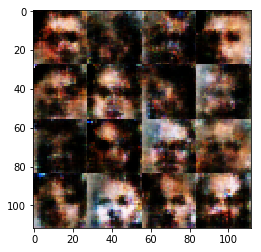

Epoch 1/1    Batch 1620... Discriminator Loss: 0.8733... Generator Loss: 1.5155
Epoch 1/1    Batch 1640... Discriminator Loss: 0.7238... Generator Loss: 2.2139
Epoch 1/1    Batch 1660... Discriminator Loss: 1.0293... Generator Loss: 0.9561
Epoch 1/1    Batch 1680... Discriminator Loss: 0.7915... Generator Loss: 2.1696
Epoch 1/1    Batch 1700... Discriminator Loss: 0.8828... Generator Loss: 1.7948


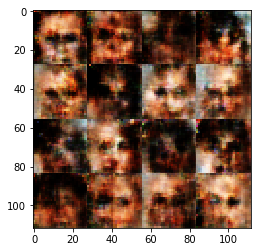

Epoch 1/1    Batch 1720... Discriminator Loss: 0.9392... Generator Loss: 1.7080
Epoch 1/1    Batch 1740... Discriminator Loss: 0.8202... Generator Loss: 2.2306
Epoch 1/1    Batch 1760... Discriminator Loss: 0.6129... Generator Loss: 1.7900
Epoch 1/1    Batch 1780... Discriminator Loss: 0.8173... Generator Loss: 1.5627
Epoch 1/1    Batch 1800... Discriminator Loss: 0.7482... Generator Loss: 1.5450


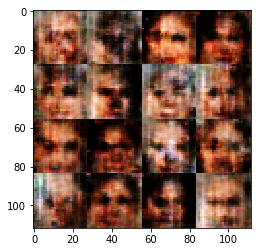

Epoch 1/1    Batch 1820... Discriminator Loss: 0.8849... Generator Loss: 1.5404
Epoch 1/1    Batch 1840... Discriminator Loss: 0.7624... Generator Loss: 1.4532
Epoch 1/1    Batch 1860... Discriminator Loss: 0.7375... Generator Loss: 1.9639
Epoch 1/1    Batch 1880... Discriminator Loss: 0.8343... Generator Loss: 1.4202
Epoch 1/1    Batch 1900... Discriminator Loss: 0.7361... Generator Loss: 2.3131


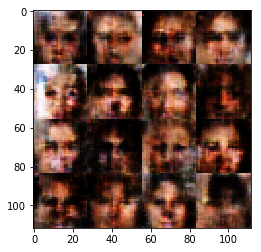

Epoch 1/1    Batch 1920... Discriminator Loss: 0.6190... Generator Loss: 2.0550
Epoch 1/1    Batch 1940... Discriminator Loss: 0.8668... Generator Loss: 1.5920
Epoch 1/1    Batch 1960... Discriminator Loss: 0.8228... Generator Loss: 1.5503
Epoch 1/1    Batch 1980... Discriminator Loss: 1.1600... Generator Loss: 1.3024
Epoch 1/1    Batch 2000... Discriminator Loss: 0.8107... Generator Loss: 1.8640


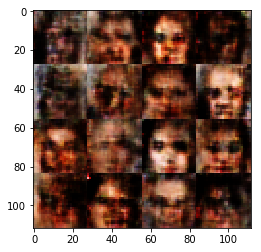

Epoch 1/1    Batch 2020... Discriminator Loss: 0.8797... Generator Loss: 1.8730
Epoch 1/1    Batch 2040... Discriminator Loss: 0.9319... Generator Loss: 1.7305
Epoch 1/1    Batch 2060... Discriminator Loss: 1.0768... Generator Loss: 1.5599
Epoch 1/1    Batch 2080... Discriminator Loss: 0.7010... Generator Loss: 1.1556
Epoch 1/1    Batch 2100... Discriminator Loss: 0.8940... Generator Loss: 1.5481


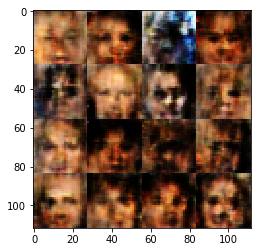

Epoch 1/1    Batch 2120... Discriminator Loss: 0.9950... Generator Loss: 1.9534
Epoch 1/1    Batch 2140... Discriminator Loss: 0.9520... Generator Loss: 1.1173
Epoch 1/1    Batch 2160... Discriminator Loss: 0.8900... Generator Loss: 1.2517
Epoch 1/1    Batch 2180... Discriminator Loss: 0.8411... Generator Loss: 1.4263
Epoch 1/1    Batch 2200... Discriminator Loss: 0.9023... Generator Loss: 1.6684


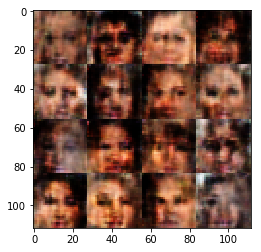

Epoch 1/1    Batch 2220... Discriminator Loss: 0.9921... Generator Loss: 1.2918
Epoch 1/1    Batch 2240... Discriminator Loss: 1.0457... Generator Loss: 1.2254
Epoch 1/1    Batch 2260... Discriminator Loss: 0.8921... Generator Loss: 2.0803
Epoch 1/1    Batch 2280... Discriminator Loss: 0.7770... Generator Loss: 1.4248
Epoch 1/1    Batch 2300... Discriminator Loss: 0.9879... Generator Loss: 1.4350


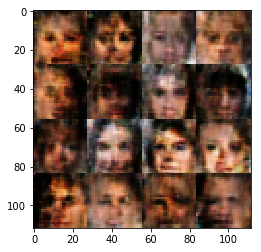

Epoch 1/1    Batch 2320... Discriminator Loss: 0.9756... Generator Loss: 1.3320
Epoch 1/1    Batch 2340... Discriminator Loss: 0.9057... Generator Loss: 2.3803
Epoch 1/1    Batch 2360... Discriminator Loss: 0.9827... Generator Loss: 1.3650
Epoch 1/1    Batch 2380... Discriminator Loss: 0.9096... Generator Loss: 1.4939
Epoch 1/1    Batch 2400... Discriminator Loss: 0.7763... Generator Loss: 1.5928


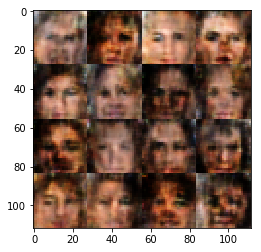

Epoch 1/1    Batch 2420... Discriminator Loss: 0.8349... Generator Loss: 1.5091
Epoch 1/1    Batch 2440... Discriminator Loss: 0.8680... Generator Loss: 1.4140
Epoch 1/1    Batch 2460... Discriminator Loss: 0.9107... Generator Loss: 1.5519
Epoch 1/1    Batch 2480... Discriminator Loss: 1.0998... Generator Loss: 1.7159
Epoch 1/1    Batch 2500... Discriminator Loss: 0.9388... Generator Loss: 0.9541


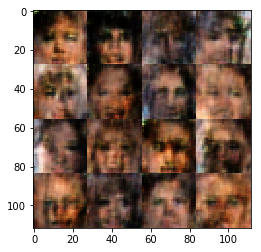

Epoch 1/1    Batch 2520... Discriminator Loss: 0.9298... Generator Loss: 1.4354
Epoch 1/1    Batch 2540... Discriminator Loss: 1.0478... Generator Loss: 1.4087
Epoch 1/1    Batch 2560... Discriminator Loss: 0.9432... Generator Loss: 1.3214
Epoch 1/1    Batch 2580... Discriminator Loss: 0.8688... Generator Loss: 1.6110
Epoch 1/1    Batch 2600... Discriminator Loss: 1.1340... Generator Loss: 0.8410


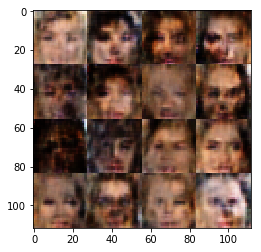

Epoch 1/1    Batch 2620... Discriminator Loss: 1.0279... Generator Loss: 1.6125
Epoch 1/1    Batch 2640... Discriminator Loss: 1.0993... Generator Loss: 1.3467
Epoch 1/1    Batch 2660... Discriminator Loss: 1.0228... Generator Loss: 1.7292
Epoch 1/1    Batch 2680... Discriminator Loss: 1.2158... Generator Loss: 1.4832
Epoch 1/1    Batch 2700... Discriminator Loss: 1.0361... Generator Loss: 1.2652


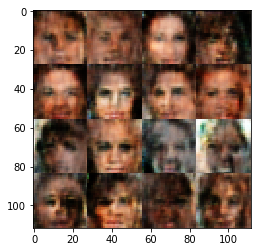

Epoch 1/1    Batch 2720... Discriminator Loss: 0.9138... Generator Loss: 1.2260
Epoch 1/1    Batch 2740... Discriminator Loss: 1.2141... Generator Loss: 1.3652
Epoch 1/1    Batch 2760... Discriminator Loss: 1.0061... Generator Loss: 1.5935
Epoch 1/1    Batch 2780... Discriminator Loss: 0.9969... Generator Loss: 1.4528
Epoch 1/1    Batch 2800... Discriminator Loss: 1.0096... Generator Loss: 1.3623


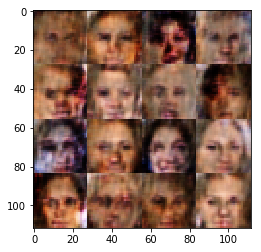

Epoch 1/1    Batch 2820... Discriminator Loss: 1.0747... Generator Loss: 0.9412
Epoch 1/1    Batch 2840... Discriminator Loss: 0.8337... Generator Loss: 1.2204
Epoch 1/1    Batch 2860... Discriminator Loss: 0.9775... Generator Loss: 1.6429
Epoch 1/1    Batch 2880... Discriminator Loss: 0.9024... Generator Loss: 1.4023
Epoch 1/1    Batch 2900... Discriminator Loss: 1.0440... Generator Loss: 1.1363


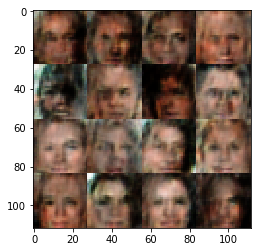

Epoch 1/1    Batch 2920... Discriminator Loss: 1.1161... Generator Loss: 1.6393
Epoch 1/1    Batch 2940... Discriminator Loss: 1.0100... Generator Loss: 1.1833
Epoch 1/1    Batch 2960... Discriminator Loss: 1.0083... Generator Loss: 1.1574
Epoch 1/1    Batch 2980... Discriminator Loss: 1.1484... Generator Loss: 1.5409
Epoch 1/1    Batch 3000... Discriminator Loss: 1.3234... Generator Loss: 1.3108


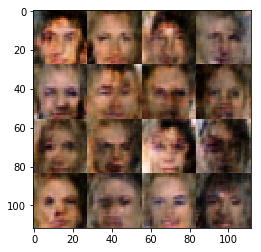

Epoch 1/1    Batch 3020... Discriminator Loss: 1.0992... Generator Loss: 1.3229
Epoch 1/1    Batch 3040... Discriminator Loss: 1.3114... Generator Loss: 1.2184
Epoch 1/1    Batch 3060... Discriminator Loss: 1.1389... Generator Loss: 1.2503
Epoch 1/1    Batch 3080... Discriminator Loss: 0.7959... Generator Loss: 1.6037
Epoch 1/1    Batch 3100... Discriminator Loss: 1.3297... Generator Loss: 1.0110


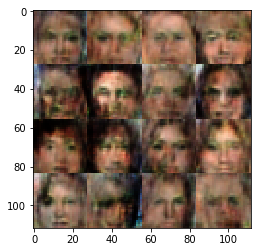

Epoch 1/1    Batch 3120... Discriminator Loss: 1.0954... Generator Loss: 1.4010
Epoch 1/1    Batch 3140... Discriminator Loss: 1.2269... Generator Loss: 1.1674
Epoch 1/1    Batch 3160... Discriminator Loss: 1.1312... Generator Loss: 1.0180
Epoch 1/1    Batch 3180... Discriminator Loss: 1.0894... Generator Loss: 1.4491
Epoch 1/1    Batch 3200... Discriminator Loss: 1.2048... Generator Loss: 0.7170


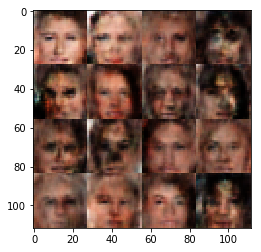

Epoch 1/1    Batch 3220... Discriminator Loss: 1.1648... Generator Loss: 0.9710
Epoch 1/1    Batch 3240... Discriminator Loss: 0.9881... Generator Loss: 1.1609
Epoch 1/1    Batch 3260... Discriminator Loss: 1.0590... Generator Loss: 1.1288
Epoch 1/1    Batch 3280... Discriminator Loss: 0.8862... Generator Loss: 1.2995
Epoch 1/1    Batch 3300... Discriminator Loss: 1.0499... Generator Loss: 1.1120


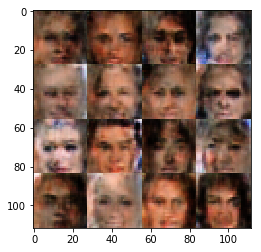

Epoch 1/1    Batch 3320... Discriminator Loss: 1.0927... Generator Loss: 1.7557
Epoch 1/1    Batch 3340... Discriminator Loss: 1.3114... Generator Loss: 1.0770
Epoch 1/1    Batch 3360... Discriminator Loss: 0.9181... Generator Loss: 1.2078
Epoch 1/1    Batch 3380... Discriminator Loss: 1.1490... Generator Loss: 0.8357
Epoch 1/1    Batch 3400... Discriminator Loss: 1.2389... Generator Loss: 1.1974


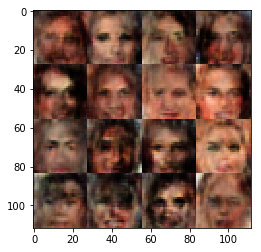

Epoch 1/1    Batch 3420... Discriminator Loss: 0.9023... Generator Loss: 1.5507
Epoch 1/1    Batch 3440... Discriminator Loss: 0.9979... Generator Loss: 1.3027
Epoch 1/1    Batch 3460... Discriminator Loss: 1.1271... Generator Loss: 0.9928
Epoch 1/1    Batch 3480... Discriminator Loss: 1.0805... Generator Loss: 0.9911
Epoch 1/1    Batch 3500... Discriminator Loss: 0.8668... Generator Loss: 1.3617


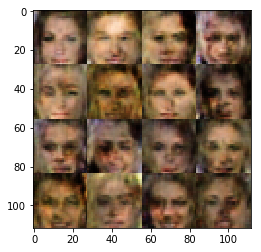

Epoch 1/1    Batch 3520... Discriminator Loss: 1.1987... Generator Loss: 1.3314
Epoch 1/1    Batch 3540... Discriminator Loss: 1.2032... Generator Loss: 1.0043
Epoch 1/1    Batch 3560... Discriminator Loss: 1.3856... Generator Loss: 1.0332
Epoch 1/1    Batch 3580... Discriminator Loss: 1.4069... Generator Loss: 1.0304
Epoch 1/1    Batch 3600... Discriminator Loss: 1.2961... Generator Loss: 1.0294


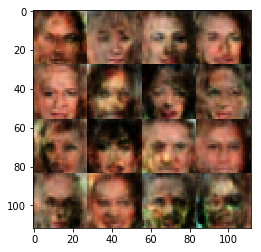

Epoch 1/1    Batch 3620... Discriminator Loss: 1.0741... Generator Loss: 1.1850
Epoch 1/1    Batch 3640... Discriminator Loss: 0.8907... Generator Loss: 1.3355
Epoch 1/1    Batch 3660... Discriminator Loss: 1.1543... Generator Loss: 1.4123
Epoch 1/1    Batch 3680... Discriminator Loss: 1.1413... Generator Loss: 0.9619
Epoch 1/1    Batch 3700... Discriminator Loss: 1.1332... Generator Loss: 1.2810


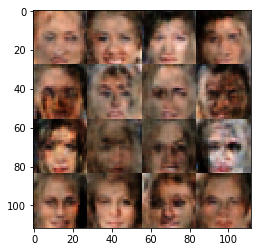

Epoch 1/1    Batch 3720... Discriminator Loss: 1.0259... Generator Loss: 0.9893
Epoch 1/1    Batch 3740... Discriminator Loss: 1.1340... Generator Loss: 1.1341
Epoch 1/1    Batch 3760... Discriminator Loss: 1.2939... Generator Loss: 1.1035
Epoch 1/1    Batch 3780... Discriminator Loss: 1.1174... Generator Loss: 0.9441
Epoch 1/1    Batch 3800... Discriminator Loss: 1.1977... Generator Loss: 1.1739


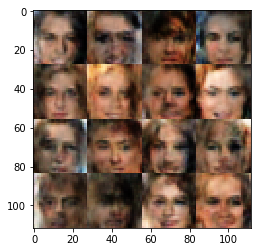

Epoch 1/1    Batch 3820... Discriminator Loss: 1.2192... Generator Loss: 1.1444
Epoch 1/1    Batch 3840... Discriminator Loss: 1.1609... Generator Loss: 1.4031
Epoch 1/1    Batch 3860... Discriminator Loss: 1.1001... Generator Loss: 1.2310
Epoch 1/1    Batch 3880... Discriminator Loss: 1.0789... Generator Loss: 0.9434
Epoch 1/1    Batch 3900... Discriminator Loss: 0.9306... Generator Loss: 1.2458


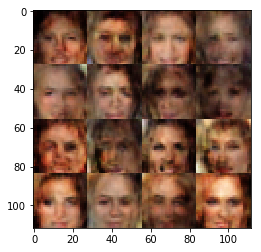

Epoch 1/1    Batch 3920... Discriminator Loss: 0.9883... Generator Loss: 1.4083
Epoch 1/1    Batch 3940... Discriminator Loss: 1.2056... Generator Loss: 0.8848
Epoch 1/1    Batch 3960... Discriminator Loss: 1.2189... Generator Loss: 1.0768
Epoch 1/1    Batch 3980... Discriminator Loss: 1.2155... Generator Loss: 0.8891
Epoch 1/1    Batch 4000... Discriminator Loss: 0.9822... Generator Loss: 1.4634


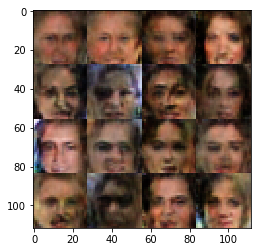

Epoch 1/1    Batch 4020... Discriminator Loss: 1.0613... Generator Loss: 1.2289
Epoch 1/1    Batch 4040... Discriminator Loss: 1.1860... Generator Loss: 1.0921
Epoch 1/1    Batch 4060... Discriminator Loss: 1.0538... Generator Loss: 1.2645
Epoch 1/1    Batch 4080... Discriminator Loss: 1.0135... Generator Loss: 1.1407
Epoch 1/1    Batch 4100... Discriminator Loss: 1.3607... Generator Loss: 1.2558


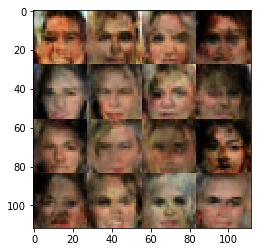

Epoch 1/1    Batch 4120... Discriminator Loss: 1.1415... Generator Loss: 1.3096
Epoch 1/1    Batch 4140... Discriminator Loss: 1.2129... Generator Loss: 1.0998
Epoch 1/1    Batch 4160... Discriminator Loss: 1.2787... Generator Loss: 1.2655
Epoch 1/1    Batch 4180... Discriminator Loss: 1.1093... Generator Loss: 1.1335
Epoch 1/1    Batch 4200... Discriminator Loss: 1.0446... Generator Loss: 1.3580


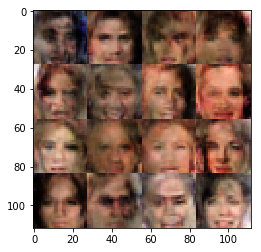

Epoch 1/1    Batch 4220... Discriminator Loss: 1.1136... Generator Loss: 1.3551
Epoch 1/1    Batch 4240... Discriminator Loss: 1.2808... Generator Loss: 0.8951
Epoch 1/1    Batch 4260... Discriminator Loss: 1.1872... Generator Loss: 0.7089
Epoch 1/1    Batch 4280... Discriminator Loss: 1.4463... Generator Loss: 0.9464
Epoch 1/1    Batch 4300... Discriminator Loss: 1.3439... Generator Loss: 1.2126


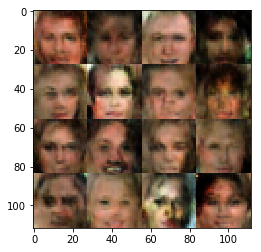

Epoch 1/1    Batch 4320... Discriminator Loss: 1.2519... Generator Loss: 1.6120
Epoch 1/1    Batch 4340... Discriminator Loss: 1.2625... Generator Loss: 1.0576
Epoch 1/1    Batch 4360... Discriminator Loss: 1.2004... Generator Loss: 1.0976
Epoch 1/1    Batch 4380... Discriminator Loss: 1.2610... Generator Loss: 1.1856
Epoch 1/1    Batch 4400... Discriminator Loss: 1.0931... Generator Loss: 1.0033


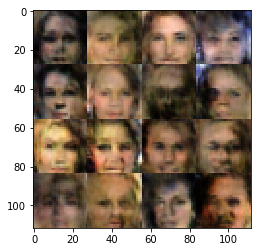

Epoch 1/1    Batch 4420... Discriminator Loss: 1.1690... Generator Loss: 1.4007
Epoch 1/1    Batch 4440... Discriminator Loss: 1.2190... Generator Loss: 0.8852
Epoch 1/1    Batch 4460... Discriminator Loss: 1.1844... Generator Loss: 0.9152
Epoch 1/1    Batch 4480... Discriminator Loss: 1.1277... Generator Loss: 1.0162
Epoch 1/1    Batch 4500... Discriminator Loss: 1.1155... Generator Loss: 1.0765


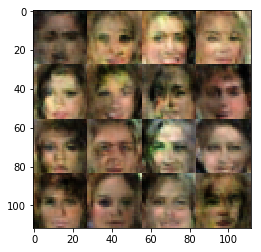

Epoch 1/1    Batch 4520... Discriminator Loss: 1.2780... Generator Loss: 0.9343
Epoch 1/1    Batch 4540... Discriminator Loss: 1.0024... Generator Loss: 1.1748
Epoch 1/1    Batch 4560... Discriminator Loss: 1.3322... Generator Loss: 0.9357
Epoch 1/1    Batch 4580... Discriminator Loss: 1.1343... Generator Loss: 1.1418
Epoch 1/1    Batch 4600... Discriminator Loss: 1.4160... Generator Loss: 0.9346


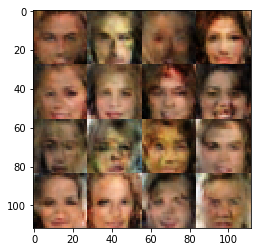

Epoch 1/1    Batch 4620... Discriminator Loss: 1.2027... Generator Loss: 1.0711
Epoch 1/1    Batch 4640... Discriminator Loss: 0.9732... Generator Loss: 1.4413
Epoch 1/1    Batch 4660... Discriminator Loss: 1.1951... Generator Loss: 1.1910
Epoch 1/1    Batch 4680... Discriminator Loss: 1.1328... Generator Loss: 1.0836
Epoch 1/1    Batch 4700... Discriminator Loss: 1.2954... Generator Loss: 0.8685


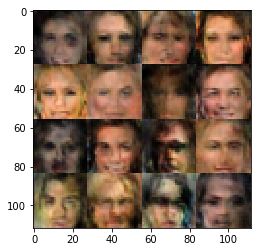

Epoch 1/1    Batch 4720... Discriminator Loss: 1.1439... Generator Loss: 1.1569
Epoch 1/1    Batch 4740... Discriminator Loss: 1.0581... Generator Loss: 1.0713
Epoch 1/1    Batch 4760... Discriminator Loss: 1.2832... Generator Loss: 1.2915
Epoch 1/1    Batch 4780... Discriminator Loss: 1.1187... Generator Loss: 0.9112
Epoch 1/1    Batch 4800... Discriminator Loss: 1.1519... Generator Loss: 1.0764


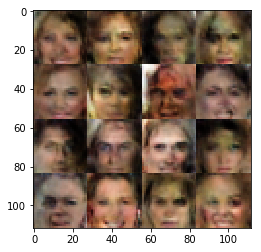

Epoch 1/1    Batch 4820... Discriminator Loss: 1.3390... Generator Loss: 1.0900
Epoch 1/1    Batch 4840... Discriminator Loss: 1.3091... Generator Loss: 1.1225
Epoch 1/1    Batch 4860... Discriminator Loss: 1.3596... Generator Loss: 1.2109
Epoch 1/1    Batch 4880... Discriminator Loss: 1.2314... Generator Loss: 1.0433
Epoch 1/1    Batch 4900... Discriminator Loss: 1.2460... Generator Loss: 1.2575


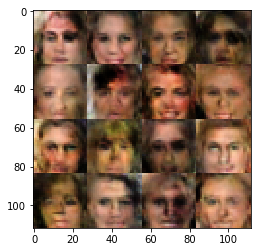

Epoch 1/1    Batch 4920... Discriminator Loss: 1.4570... Generator Loss: 0.8789
Epoch 1/1    Batch 4940... Discriminator Loss: 1.1822... Generator Loss: 1.1770
Epoch 1/1    Batch 4960... Discriminator Loss: 1.2818... Generator Loss: 1.0111
Epoch 1/1    Batch 4980... Discriminator Loss: 1.2544... Generator Loss: 1.0597
Epoch 1/1    Batch 5000... Discriminator Loss: 1.2116... Generator Loss: 1.2793


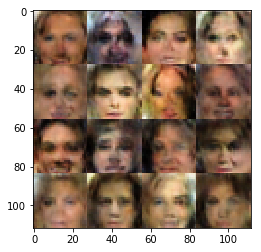

Epoch 1/1    Batch 5020... Discriminator Loss: 1.1958... Generator Loss: 0.9501
Epoch 1/1    Batch 5040... Discriminator Loss: 1.2295... Generator Loss: 0.9245
Epoch 1/1    Batch 5060... Discriminator Loss: 1.2742... Generator Loss: 1.1990
Epoch 1/1    Batch 5080... Discriminator Loss: 1.0337... Generator Loss: 1.1961
Epoch 1/1    Batch 5100... Discriminator Loss: 1.2198... Generator Loss: 0.7837


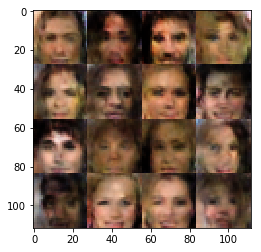

Epoch 1/1    Batch 5120... Discriminator Loss: 1.3197... Generator Loss: 1.0982
Epoch 1/1    Batch 5140... Discriminator Loss: 1.1609... Generator Loss: 1.1260
Epoch 1/1    Batch 5160... Discriminator Loss: 1.1793... Generator Loss: 0.8298
Epoch 1/1    Batch 5180... Discriminator Loss: 1.1207... Generator Loss: 1.1404
Epoch 1/1    Batch 5200... Discriminator Loss: 1.5454... Generator Loss: 0.8344


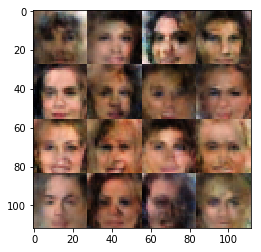

Epoch 1/1    Batch 5220... Discriminator Loss: 1.2142... Generator Loss: 0.9925
Epoch 1/1    Batch 5240... Discriminator Loss: 1.1579... Generator Loss: 1.1586
Epoch 1/1    Batch 5260... Discriminator Loss: 1.2895... Generator Loss: 1.3304
Epoch 1/1    Batch 5280... Discriminator Loss: 1.4003... Generator Loss: 1.1227
Epoch 1/1    Batch 5300... Discriminator Loss: 1.2318... Generator Loss: 1.2505


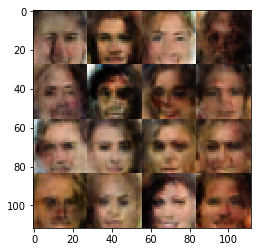

Epoch 1/1    Batch 5320... Discriminator Loss: 1.3599... Generator Loss: 1.2925
Epoch 1/1    Batch 5340... Discriminator Loss: 1.3882... Generator Loss: 0.8509
Epoch 1/1    Batch 5360... Discriminator Loss: 1.1473... Generator Loss: 1.2518
Epoch 1/1    Batch 5380... Discriminator Loss: 1.1054... Generator Loss: 1.1601
Epoch 1/1    Batch 5400... Discriminator Loss: 1.1378... Generator Loss: 1.0548


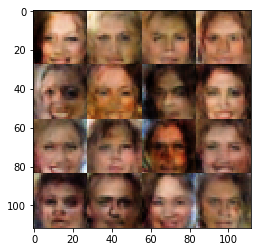

Epoch 1/1    Batch 5420... Discriminator Loss: 1.1633... Generator Loss: 1.0733
Epoch 1/1    Batch 5440... Discriminator Loss: 1.2369... Generator Loss: 1.0189
Epoch 1/1    Batch 5460... Discriminator Loss: 1.2154... Generator Loss: 1.1401
Epoch 1/1    Batch 5480... Discriminator Loss: 1.2902... Generator Loss: 0.8637
Epoch 1/1    Batch 5500... Discriminator Loss: 1.2435... Generator Loss: 1.2946


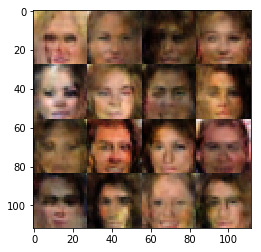

Epoch 1/1    Batch 5520... Discriminator Loss: 1.2200... Generator Loss: 1.3089
Epoch 1/1    Batch 5540... Discriminator Loss: 1.2937... Generator Loss: 0.9920
Epoch 1/1    Batch 5560... Discriminator Loss: 1.1802... Generator Loss: 0.7832
Epoch 1/1    Batch 5580... Discriminator Loss: 1.2795... Generator Loss: 0.9428
Epoch 1/1    Batch 5600... Discriminator Loss: 1.1912... Generator Loss: 1.1515


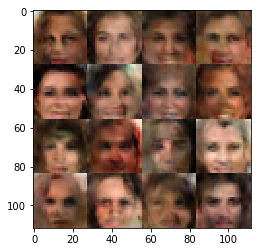

Epoch 1/1    Batch 5620... Discriminator Loss: 1.2496... Generator Loss: 0.8816
Epoch 1/1    Batch 5640... Discriminator Loss: 1.1890... Generator Loss: 0.8970
Epoch 1/1    Batch 5660... Discriminator Loss: 1.1516... Generator Loss: 1.1011
Epoch 1/1    Batch 5680... Discriminator Loss: 1.3012... Generator Loss: 1.0453
Epoch 1/1    Batch 5700... Discriminator Loss: 1.1662... Generator Loss: 1.3391


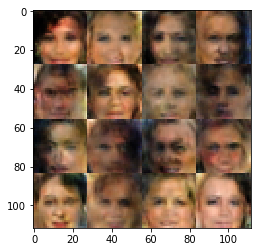

Epoch 1/1    Batch 5720... Discriminator Loss: 1.1621... Generator Loss: 0.9034
Epoch 1/1    Batch 5740... Discriminator Loss: 1.2102... Generator Loss: 1.3121
Epoch 1/1    Batch 5760... Discriminator Loss: 1.1748... Generator Loss: 1.0016
Epoch 1/1    Batch 5780... Discriminator Loss: 1.2260... Generator Loss: 1.1540
Epoch 1/1    Batch 5800... Discriminator Loss: 0.9727... Generator Loss: 0.9483


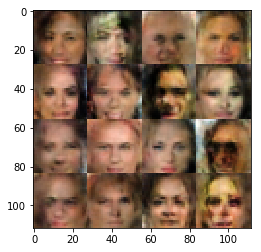

Epoch 1/1    Batch 5820... Discriminator Loss: 1.1345... Generator Loss: 0.9154
Epoch 1/1    Batch 5840... Discriminator Loss: 1.0273... Generator Loss: 1.3098
Epoch 1/1    Batch 5860... Discriminator Loss: 1.1703... Generator Loss: 0.9252
Epoch 1/1    Batch 5880... Discriminator Loss: 1.3870... Generator Loss: 1.0415
Epoch 1/1    Batch 5900... Discriminator Loss: 1.1885... Generator Loss: 1.0782


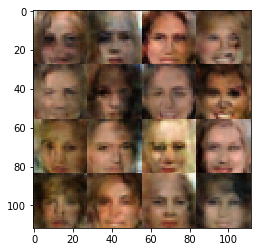

Epoch 1/1    Batch 5920... Discriminator Loss: 1.1984... Generator Loss: 1.1111
Epoch 1/1    Batch 5940... Discriminator Loss: 0.9751... Generator Loss: 1.1892
Epoch 1/1    Batch 5960... Discriminator Loss: 1.1955... Generator Loss: 1.3382
Epoch 1/1    Batch 5980... Discriminator Loss: 1.1299... Generator Loss: 1.2312
Epoch 1/1    Batch 6000... Discriminator Loss: 1.2306... Generator Loss: 0.9597


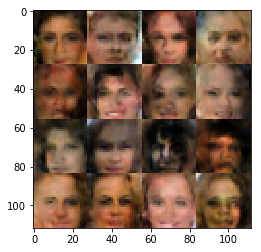

Epoch 1/1    Batch 6020... Discriminator Loss: 1.1955... Generator Loss: 1.1209
Epoch 1/1    Batch 6040... Discriminator Loss: 1.4046... Generator Loss: 1.0615
Epoch 1/1    Batch 6060... Discriminator Loss: 1.1578... Generator Loss: 1.1677
Epoch 1/1    Batch 6080... Discriminator Loss: 1.2158... Generator Loss: 1.0233
Epoch 1/1    Batch 6100... Discriminator Loss: 1.3799... Generator Loss: 0.9859


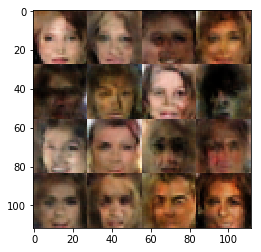

Epoch 1/1    Batch 6120... Discriminator Loss: 1.1796... Generator Loss: 1.0053
Epoch 1/1    Batch 6140... Discriminator Loss: 1.1000... Generator Loss: 1.2995
Epoch 1/1    Batch 6160... Discriminator Loss: 1.3031... Generator Loss: 1.1901
Epoch 1/1    Batch 6180... Discriminator Loss: 1.0892... Generator Loss: 0.9134
Epoch 1/1    Batch 6200... Discriminator Loss: 1.1973... Generator Loss: 0.9664


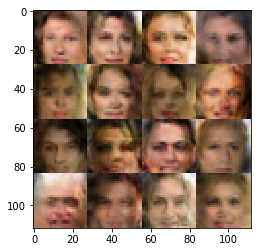

Epoch 1/1    Batch 6220... Discriminator Loss: 0.9846... Generator Loss: 0.9945
Epoch 1/1    Batch 6240... Discriminator Loss: 1.2511... Generator Loss: 1.1033
Epoch 1/1    Batch 6260... Discriminator Loss: 1.1080... Generator Loss: 1.1074
Epoch 1/1    Batch 6280... Discriminator Loss: 1.1628... Generator Loss: 1.1067
Epoch 1/1    Batch 6300... Discriminator Loss: 1.1775... Generator Loss: 1.1538


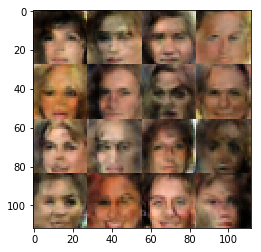

Epoch 1/1    Batch 6320... Discriminator Loss: 1.3970... Generator Loss: 0.7591
Epoch 1/1    Batch 6340... Discriminator Loss: 0.9976... Generator Loss: 1.1229
Epoch 1/1    Batch 6360... Discriminator Loss: 1.2118... Generator Loss: 0.9346
Epoch 1/1    Batch 6380... Discriminator Loss: 1.0175... Generator Loss: 1.0471
Epoch 1/1    Batch 6400... Discriminator Loss: 1.1524... Generator Loss: 1.1087


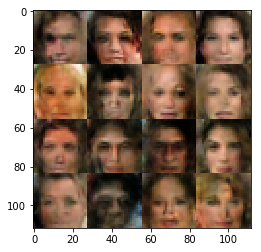

Epoch 1/1    Batch 6420... Discriminator Loss: 1.0786... Generator Loss: 1.0040
Epoch 1/1    Batch 6440... Discriminator Loss: 1.4006... Generator Loss: 1.0490
Epoch 1/1    Batch 6460... Discriminator Loss: 1.2980... Generator Loss: 0.9384
Epoch 1/1    Batch 6480... Discriminator Loss: 1.2171... Generator Loss: 0.8862
Epoch 1/1    Batch 6500... Discriminator Loss: 1.0710... Generator Loss: 1.1730


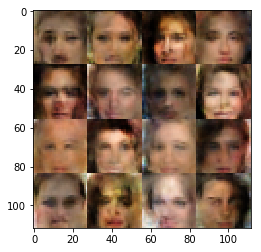

Epoch 1/1    Batch 6520... Discriminator Loss: 1.2030... Generator Loss: 1.2103
Epoch 1/1    Batch 6540... Discriminator Loss: 1.3347... Generator Loss: 1.0454
Epoch 1/1    Batch 6560... Discriminator Loss: 1.2025... Generator Loss: 1.1483
Epoch 1/1    Batch 6580... Discriminator Loss: 1.2891... Generator Loss: 0.8320
Epoch 1/1    Batch 6600... Discriminator Loss: 1.1193... Generator Loss: 1.1448


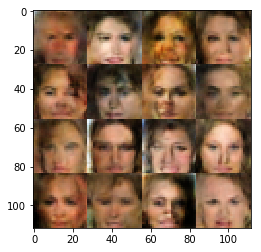

Epoch 1/1    Batch 6620... Discriminator Loss: 1.2691... Generator Loss: 0.9779
Epoch 1/1    Batch 6640... Discriminator Loss: 1.2250... Generator Loss: 1.2424
Epoch 1/1    Batch 6660... Discriminator Loss: 0.9705... Generator Loss: 0.9426
Epoch 1/1    Batch 6680... Discriminator Loss: 1.2329... Generator Loss: 1.2356
Epoch 1/1    Batch 6700... Discriminator Loss: 1.2512... Generator Loss: 1.0417


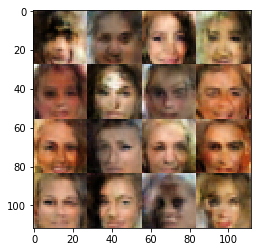

Epoch 1/1    Batch 6720... Discriminator Loss: 1.3488... Generator Loss: 0.8576
Epoch 1/1    Batch 6740... Discriminator Loss: 1.1756... Generator Loss: 1.1836
Epoch 1/1    Batch 6760... Discriminator Loss: 1.3297... Generator Loss: 1.2513
Epoch 1/1    Batch 6780... Discriminator Loss: 1.3491... Generator Loss: 1.2021
Epoch 1/1    Batch 6800... Discriminator Loss: 1.1538... Generator Loss: 1.2236


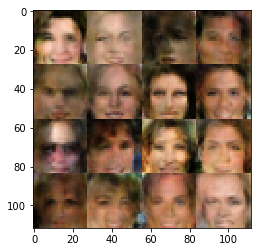

Epoch 1/1    Batch 6820... Discriminator Loss: 1.2082... Generator Loss: 1.0197
Epoch 1/1    Batch 6840... Discriminator Loss: 1.1012... Generator Loss: 1.4436
Epoch 1/1    Batch 6860... Discriminator Loss: 1.3923... Generator Loss: 0.9184
Epoch 1/1    Batch 6880... Discriminator Loss: 1.2731... Generator Loss: 0.9738
Epoch 1/1    Batch 6900... Discriminator Loss: 1.3078... Generator Loss: 1.3552


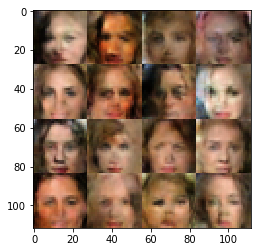

Epoch 1/1    Batch 6920... Discriminator Loss: 1.1319... Generator Loss: 1.1637
Epoch 1/1    Batch 6940... Discriminator Loss: 1.2134... Generator Loss: 1.1357
Epoch 1/1    Batch 6960... Discriminator Loss: 1.3354... Generator Loss: 1.0170
Epoch 1/1    Batch 6980... Discriminator Loss: 1.2431... Generator Loss: 0.8496
Epoch 1/1    Batch 7000... Discriminator Loss: 1.4401... Generator Loss: 1.0110


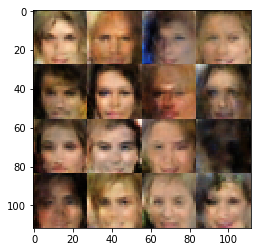

Epoch 1/1    Batch 7020... Discriminator Loss: 1.2115... Generator Loss: 0.8140
Epoch 1/1    Batch 7040... Discriminator Loss: 1.0550... Generator Loss: 1.2721
Epoch 1/1    Batch 7060... Discriminator Loss: 1.0118... Generator Loss: 1.1265
Epoch 1/1    Batch 7080... Discriminator Loss: 1.2908... Generator Loss: 0.9002
Epoch 1/1    Batch 7100... Discriminator Loss: 1.2994... Generator Loss: 0.8124


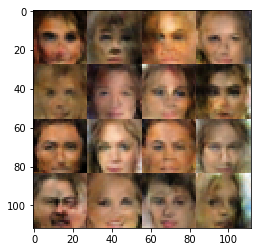

Epoch 1/1    Batch 7120... Discriminator Loss: 1.2031... Generator Loss: 1.1582
Epoch 1/1    Batch 7140... Discriminator Loss: 1.0059... Generator Loss: 1.1038
Epoch 1/1    Batch 7160... Discriminator Loss: 1.1371... Generator Loss: 1.0754
Epoch 1/1    Batch 7180... Discriminator Loss: 1.3349... Generator Loss: 1.0914
Epoch 1/1    Batch 7200... Discriminator Loss: 1.2012... Generator Loss: 1.2459


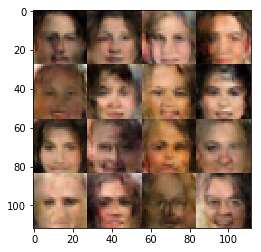

Epoch 1/1    Batch 7220... Discriminator Loss: 1.2528... Generator Loss: 0.8804
Epoch 1/1    Batch 7240... Discriminator Loss: 1.0469... Generator Loss: 0.9271
Epoch 1/1    Batch 7260... Discriminator Loss: 1.4070... Generator Loss: 0.7040
Epoch 1/1    Batch 7280... Discriminator Loss: 1.1920... Generator Loss: 1.2044
Epoch 1/1    Batch 7300... Discriminator Loss: 1.2324... Generator Loss: 1.3208


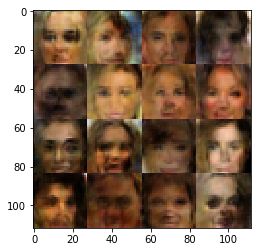

Epoch 1/1    Batch 7320... Discriminator Loss: 1.5757... Generator Loss: 0.8653
Epoch 1/1    Batch 7340... Discriminator Loss: 1.1227... Generator Loss: 1.2002
Epoch 1/1    Batch 7360... Discriminator Loss: 1.3715... Generator Loss: 0.9064
Epoch 1/1    Batch 7380... Discriminator Loss: 0.9702... Generator Loss: 0.9673
Epoch 1/1    Batch 7400... Discriminator Loss: 1.1937... Generator Loss: 1.2796


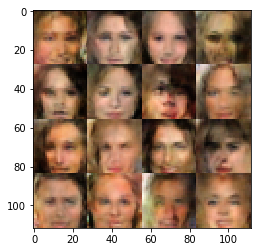

Epoch 1/1    Batch 7420... Discriminator Loss: 1.2352... Generator Loss: 0.9754
Epoch 1/1    Batch 7440... Discriminator Loss: 1.1499... Generator Loss: 0.8988
Epoch 1/1    Batch 7460... Discriminator Loss: 1.1971... Generator Loss: 1.4087
Epoch 1/1    Batch 7480... Discriminator Loss: 1.1715... Generator Loss: 0.9034
Epoch 1/1    Batch 7500... Discriminator Loss: 1.2664... Generator Loss: 1.1781


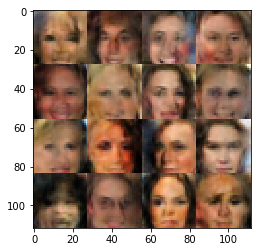

Epoch 1/1    Batch 7520... Discriminator Loss: 1.0586... Generator Loss: 1.0064
Epoch 1/1    Batch 7540... Discriminator Loss: 1.1834... Generator Loss: 1.0727
Epoch 1/1    Batch 7560... Discriminator Loss: 1.0947... Generator Loss: 1.0916
Epoch 1/1    Batch 7580... Discriminator Loss: 1.6271... Generator Loss: 1.1172
Epoch 1/1    Batch 7600... Discriminator Loss: 1.3473... Generator Loss: 0.9310


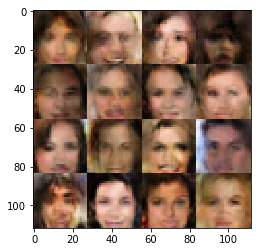

Epoch 1/1    Batch 7620... Discriminator Loss: 1.3117... Generator Loss: 1.0297
Epoch 1/1    Batch 7640... Discriminator Loss: 1.1682... Generator Loss: 1.0887
Epoch 1/1    Batch 7660... Discriminator Loss: 1.2345... Generator Loss: 1.1256
Epoch 1/1    Batch 7680... Discriminator Loss: 1.0970... Generator Loss: 0.9012
Epoch 1/1    Batch 7700... Discriminator Loss: 0.9296... Generator Loss: 1.4212


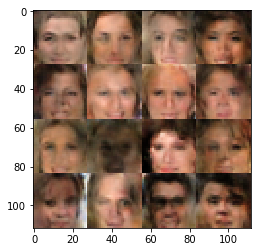

Epoch 1/1    Batch 7720... Discriminator Loss: 1.2523... Generator Loss: 1.0305
Epoch 1/1    Batch 7740... Discriminator Loss: 1.1652... Generator Loss: 1.1869
Epoch 1/1    Batch 7760... Discriminator Loss: 1.4396... Generator Loss: 1.1475
Epoch 1/1    Batch 7780... Discriminator Loss: 1.1480... Generator Loss: 0.9699
Epoch 1/1    Batch 7800... Discriminator Loss: 1.3352... Generator Loss: 1.1703


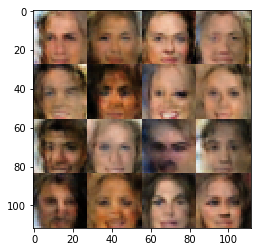

Epoch 1/1    Batch 7820... Discriminator Loss: 1.1881... Generator Loss: 1.1709
Epoch 1/1    Batch 7840... Discriminator Loss: 1.1406... Generator Loss: 1.1148
Epoch 1/1    Batch 7860... Discriminator Loss: 1.2556... Generator Loss: 0.9517
Epoch 1/1    Batch 7880... Discriminator Loss: 1.2145... Generator Loss: 1.1091
Epoch 1/1    Batch 7900... Discriminator Loss: 1.0277... Generator Loss: 1.2984


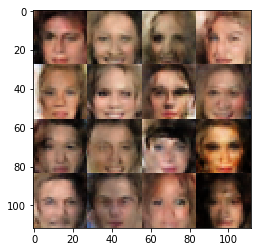

Epoch 1/1    Batch 7920... Discriminator Loss: 1.2682... Generator Loss: 1.1497
Epoch 1/1    Batch 7940... Discriminator Loss: 1.2855... Generator Loss: 0.7989
Epoch 1/1    Batch 7960... Discriminator Loss: 1.1257... Generator Loss: 1.0851
Epoch 1/1    Batch 7980... Discriminator Loss: 1.2620... Generator Loss: 0.8539
Epoch 1/1    Batch 8000... Discriminator Loss: 1.0470... Generator Loss: 0.9216


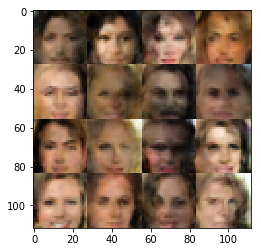

Epoch 1/1    Batch 8020... Discriminator Loss: 1.1304... Generator Loss: 1.2372
Epoch 1/1    Batch 8040... Discriminator Loss: 1.3439... Generator Loss: 0.9437
Epoch 1/1    Batch 8060... Discriminator Loss: 1.2110... Generator Loss: 0.8520
Epoch 1/1    Batch 8080... Discriminator Loss: 0.9497... Generator Loss: 1.1030
Epoch 1/1    Batch 8100... Discriminator Loss: 1.0607... Generator Loss: 1.1666


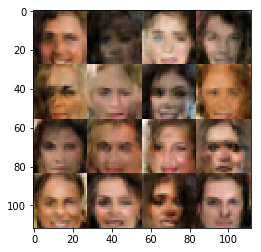

Epoch 1/1    Batch 8120... Discriminator Loss: 1.0359... Generator Loss: 1.1682
Epoch 1/1    Batch 8140... Discriminator Loss: 1.1296... Generator Loss: 0.7160
Epoch 1/1    Batch 8160... Discriminator Loss: 1.0946... Generator Loss: 1.4571
Epoch 1/1    Batch 8180... Discriminator Loss: 1.2139... Generator Loss: 0.8368
Epoch 1/1    Batch 8200... Discriminator Loss: 0.9619... Generator Loss: 1.1334


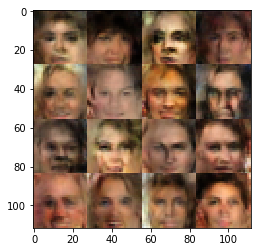

Epoch 1/1    Batch 8220... Discriminator Loss: 1.0600... Generator Loss: 1.0065
Epoch 1/1    Batch 8240... Discriminator Loss: 1.1999... Generator Loss: 1.1665
Epoch 1/1    Batch 8260... Discriminator Loss: 1.0857... Generator Loss: 1.0788
Epoch 1/1    Batch 8280... Discriminator Loss: 1.1270... Generator Loss: 0.9335
Epoch 1/1    Batch 8300... Discriminator Loss: 1.1907... Generator Loss: 0.7663


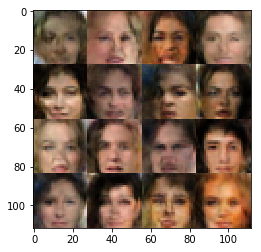

Epoch 1/1    Batch 8320... Discriminator Loss: 1.2042... Generator Loss: 1.0576
Epoch 1/1    Batch 8340... Discriminator Loss: 1.2883... Generator Loss: 0.9247
Epoch 1/1    Batch 8360... Discriminator Loss: 1.2239... Generator Loss: 1.0385
Epoch 1/1    Batch 8380... Discriminator Loss: 1.2239... Generator Loss: 1.3203
Epoch 1/1    Batch 8400... Discriminator Loss: 1.2177... Generator Loss: 1.2241


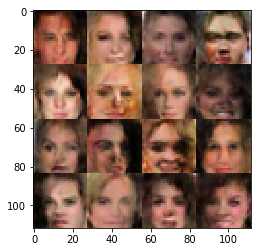

Epoch 1/1    Batch 8420... Discriminator Loss: 1.1500... Generator Loss: 1.1441
Epoch 1/1    Batch 8440... Discriminator Loss: 1.3738... Generator Loss: 1.0567
Epoch 1/1    Batch 8460... Discriminator Loss: 1.1568... Generator Loss: 0.7301
Epoch 1/1    Batch 8480... Discriminator Loss: 0.9668... Generator Loss: 1.2003
Epoch 1/1    Batch 8500... Discriminator Loss: 1.2924... Generator Loss: 1.1270


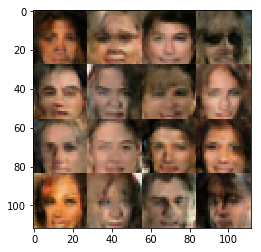

Epoch 1/1    Batch 8520... Discriminator Loss: 1.1358... Generator Loss: 1.0245
Epoch 1/1    Batch 8540... Discriminator Loss: 1.2632... Generator Loss: 1.2643
Epoch 1/1    Batch 8560... Discriminator Loss: 1.1346... Generator Loss: 1.1506
Epoch 1/1    Batch 8580... Discriminator Loss: 1.3497... Generator Loss: 0.8349
Epoch 1/1    Batch 8600... Discriminator Loss: 0.9658... Generator Loss: 1.1695


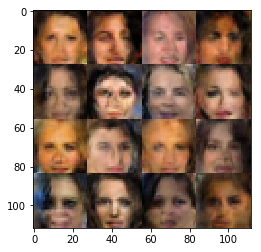

Epoch 1/1    Batch 8620... Discriminator Loss: 1.0548... Generator Loss: 1.1153
Epoch 1/1    Batch 8640... Discriminator Loss: 1.2713... Generator Loss: 0.8693
Epoch 1/1    Batch 8660... Discriminator Loss: 1.3792... Generator Loss: 0.8157
Epoch 1/1    Batch 8680... Discriminator Loss: 1.1790... Generator Loss: 1.0752
Epoch 1/1    Batch 8700... Discriminator Loss: 1.1819... Generator Loss: 1.0334


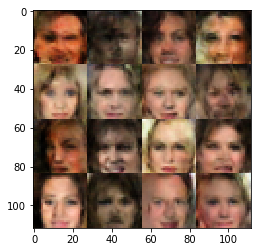

Epoch 1/1    Batch 8720... Discriminator Loss: 1.0677... Generator Loss: 0.9223
Epoch 1/1    Batch 8740... Discriminator Loss: 1.1734... Generator Loss: 1.1396
Epoch 1/1    Batch 8760... Discriminator Loss: 0.9752... Generator Loss: 0.8877
Epoch 1/1    Batch 8780... Discriminator Loss: 1.1498... Generator Loss: 1.1705
Epoch 1/1    Batch 8800... Discriminator Loss: 1.0994... Generator Loss: 1.1600


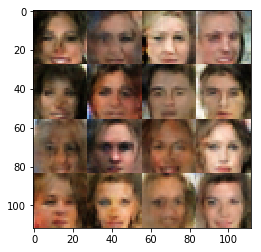

Epoch 1/1    Batch 8820... Discriminator Loss: 1.2037... Generator Loss: 1.1110
Epoch 1/1    Batch 8840... Discriminator Loss: 1.2472... Generator Loss: 0.9918
Epoch 1/1    Batch 8860... Discriminator Loss: 1.0451... Generator Loss: 0.8740
Epoch 1/1    Batch 8880... Discriminator Loss: 1.0169... Generator Loss: 1.1347
Epoch 1/1    Batch 8900... Discriminator Loss: 1.3473... Generator Loss: 0.8682


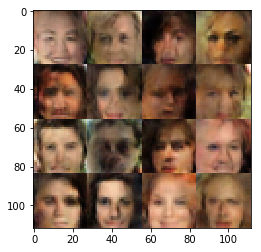

Epoch 1/1    Batch 8920... Discriminator Loss: 1.0993... Generator Loss: 1.1695
Epoch 1/1    Batch 8940... Discriminator Loss: 1.3473... Generator Loss: 0.9031
Epoch 1/1    Batch 8960... Discriminator Loss: 1.3825... Generator Loss: 0.8799
Epoch 1/1    Batch 8980... Discriminator Loss: 1.3357... Generator Loss: 0.8603
Epoch 1/1    Batch 9000... Discriminator Loss: 1.1792... Generator Loss: 1.1712


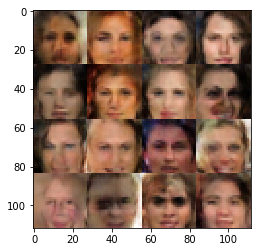

Epoch 1/1    Batch 9020... Discriminator Loss: 1.3105... Generator Loss: 0.9341
Epoch 1/1    Batch 9040... Discriminator Loss: 1.6145... Generator Loss: 0.7766
Epoch 1/1    Batch 9060... Discriminator Loss: 1.3590... Generator Loss: 0.9585
Epoch 1/1    Batch 9080... Discriminator Loss: 1.3177... Generator Loss: 1.0205
Epoch 1/1    Batch 9100... Discriminator Loss: 1.1395... Generator Loss: 1.2404


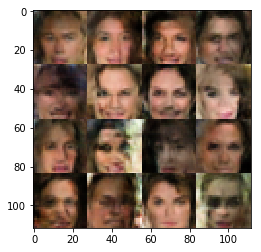

Epoch 1/1    Batch 9120... Discriminator Loss: 0.9475... Generator Loss: 1.0656
Epoch 1/1    Batch 9140... Discriminator Loss: 1.1673... Generator Loss: 1.3007
Epoch 1/1    Batch 9160... Discriminator Loss: 1.2025... Generator Loss: 0.9068
Epoch 1/1    Batch 9180... Discriminator Loss: 1.0516... Generator Loss: 0.8339
Epoch 1/1    Batch 9200... Discriminator Loss: 1.0541... Generator Loss: 1.0925


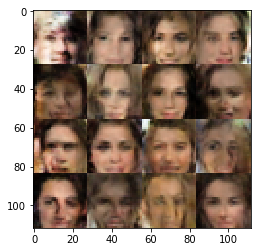

Epoch 1/1    Batch 9220... Discriminator Loss: 1.0679... Generator Loss: 0.9687
Epoch 1/1    Batch 9240... Discriminator Loss: 1.1484... Generator Loss: 1.0909
Epoch 1/1    Batch 9260... Discriminator Loss: 1.3673... Generator Loss: 1.0435
Epoch 1/1    Batch 9280... Discriminator Loss: 1.1226... Generator Loss: 1.3305
Epoch 1/1    Batch 9300... Discriminator Loss: 1.2209... Generator Loss: 1.0365


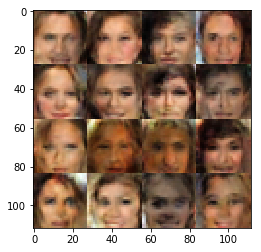

Epoch 1/1    Batch 9320... Discriminator Loss: 1.0679... Generator Loss: 1.0057
Epoch 1/1    Batch 9340... Discriminator Loss: 1.1007... Generator Loss: 1.0353
Epoch 1/1    Batch 9360... Discriminator Loss: 1.0856... Generator Loss: 0.9771
Epoch 1/1    Batch 9380... Discriminator Loss: 1.0324... Generator Loss: 1.1076
Epoch 1/1    Batch 9400... Discriminator Loss: 1.1508... Generator Loss: 1.2263


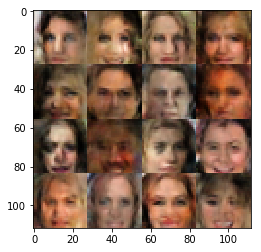

Epoch 1/1    Batch 9420... Discriminator Loss: 0.8747... Generator Loss: 1.2477
Epoch 1/1    Batch 9440... Discriminator Loss: 1.1594... Generator Loss: 1.0002
Epoch 1/1    Batch 9460... Discriminator Loss: 1.2928... Generator Loss: 1.0144
Epoch 1/1    Batch 9480... Discriminator Loss: 1.3648... Generator Loss: 1.0071
Epoch 1/1    Batch 9500... Discriminator Loss: 1.1223... Generator Loss: 0.9296


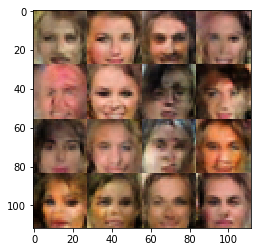

Epoch 1/1    Batch 9520... Discriminator Loss: 1.1532... Generator Loss: 1.0591
Epoch 1/1    Batch 9540... Discriminator Loss: 1.2066... Generator Loss: 1.0601
Epoch 1/1    Batch 9560... Discriminator Loss: 1.2196... Generator Loss: 1.0086
Epoch 1/1    Batch 9580... Discriminator Loss: 1.3802... Generator Loss: 1.2596
Epoch 1/1    Batch 9600... Discriminator Loss: 1.1328... Generator Loss: 1.1960


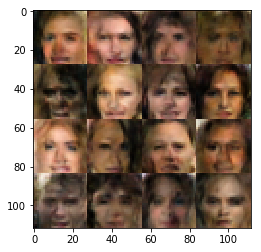

Epoch 1/1    Batch 9620... Discriminator Loss: 1.1314... Generator Loss: 1.0329
Epoch 1/1    Batch 9640... Discriminator Loss: 1.2497... Generator Loss: 0.9065
Epoch 1/1    Batch 9660... Discriminator Loss: 1.1187... Generator Loss: 1.0691
Epoch 1/1    Batch 9680... Discriminator Loss: 1.1848... Generator Loss: 1.1856
Epoch 1/1    Batch 9700... Discriminator Loss: 1.0662... Generator Loss: 0.9317


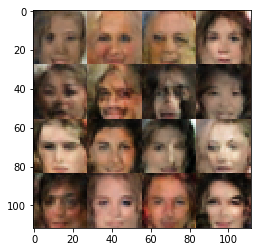

Epoch 1/1    Batch 9720... Discriminator Loss: 1.2181... Generator Loss: 1.0930
Epoch 1/1    Batch 9740... Discriminator Loss: 1.1775... Generator Loss: 1.1291
Epoch 1/1    Batch 9760... Discriminator Loss: 1.1321... Generator Loss: 1.0235
Epoch 1/1    Batch 9780... Discriminator Loss: 1.3054... Generator Loss: 0.8330
Epoch 1/1    Batch 9800... Discriminator Loss: 0.9765... Generator Loss: 1.1741


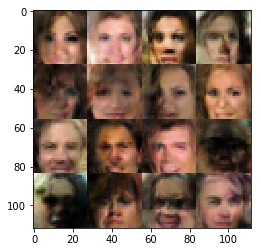

Epoch 1/1    Batch 9820... Discriminator Loss: 1.1514... Generator Loss: 1.2793
Epoch 1/1    Batch 9840... Discriminator Loss: 1.1931... Generator Loss: 0.9230
Epoch 1/1    Batch 9860... Discriminator Loss: 0.9969... Generator Loss: 1.3850
Epoch 1/1    Batch 9880... Discriminator Loss: 1.2297... Generator Loss: 1.2988
Epoch 1/1    Batch 9900... Discriminator Loss: 1.3448... Generator Loss: 1.0136


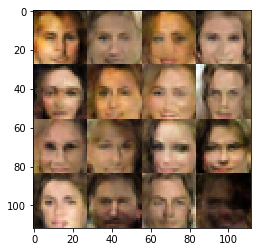

Epoch 1/1    Batch 9920... Discriminator Loss: 1.1407... Generator Loss: 0.9721
Epoch 1/1    Batch 9940... Discriminator Loss: 1.0990... Generator Loss: 1.1657
Epoch 1/1    Batch 9960... Discriminator Loss: 1.2587... Generator Loss: 0.9006
Epoch 1/1    Batch 9980... Discriminator Loss: 1.2178... Generator Loss: 0.9594
Epoch 1/1    Batch 10000... Discriminator Loss: 1.2929... Generator Loss: 1.0615


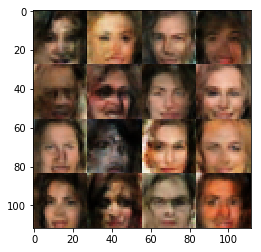

Epoch 1/1    Batch 10020... Discriminator Loss: 1.0869... Generator Loss: 1.1663
Epoch 1/1    Batch 10040... Discriminator Loss: 1.1545... Generator Loss: 1.0061
Epoch 1/1    Batch 10060... Discriminator Loss: 1.1584... Generator Loss: 0.8568
Epoch 1/1    Batch 10080... Discriminator Loss: 1.1897... Generator Loss: 1.1119
Epoch 1/1    Batch 10100... Discriminator Loss: 1.2944... Generator Loss: 0.9341


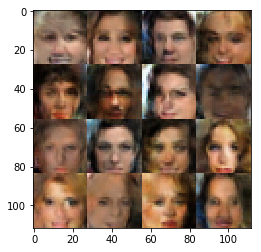

Epoch 1/1    Batch 10120... Discriminator Loss: 1.1818... Generator Loss: 1.1208
Epoch 1/1    Batch 10140... Discriminator Loss: 0.9691... Generator Loss: 1.1752
Epoch 1/1    Batch 10160... Discriminator Loss: 1.2203... Generator Loss: 1.1053
Epoch 1/1    Batch 10180... Discriminator Loss: 1.2309... Generator Loss: 1.1425
Epoch 1/1    Batch 10200... Discriminator Loss: 1.2477... Generator Loss: 0.7333


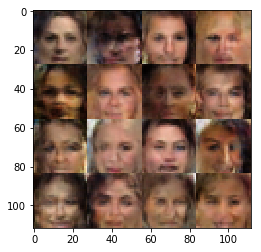

Epoch 1/1    Batch 10220... Discriminator Loss: 1.1881... Generator Loss: 1.1499
Epoch 1/1    Batch 10240... Discriminator Loss: 1.2745... Generator Loss: 1.2042
Epoch 1/1    Batch 10260... Discriminator Loss: 1.2431... Generator Loss: 1.0577
Epoch 1/1    Batch 10280... Discriminator Loss: 1.2195... Generator Loss: 0.9819
Epoch 1/1    Batch 10300... Discriminator Loss: 1.3890... Generator Loss: 1.0136


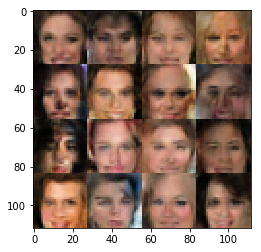

Epoch 1/1    Batch 10320... Discriminator Loss: 1.2157... Generator Loss: 0.9472
Epoch 1/1    Batch 10340... Discriminator Loss: 1.0273... Generator Loss: 1.1635
Epoch 1/1    Batch 10360... Discriminator Loss: 1.1474... Generator Loss: 1.2796
Epoch 1/1    Batch 10380... Discriminator Loss: 1.1217... Generator Loss: 1.1000
Epoch 1/1    Batch 10400... Discriminator Loss: 1.4117... Generator Loss: 1.1135


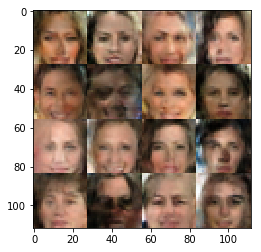

Epoch 1/1    Batch 10420... Discriminator Loss: 1.2739... Generator Loss: 1.1110
Epoch 1/1    Batch 10440... Discriminator Loss: 1.2171... Generator Loss: 0.9336
Epoch 1/1    Batch 10460... Discriminator Loss: 1.0703... Generator Loss: 1.2490
Epoch 1/1    Batch 10480... Discriminator Loss: 1.1973... Generator Loss: 1.2985
Epoch 1/1    Batch 10500... Discriminator Loss: 1.0593... Generator Loss: 0.9855


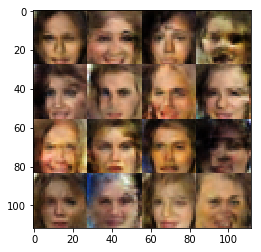

Epoch 1/1    Batch 10520... Discriminator Loss: 1.1238... Generator Loss: 1.1352
Epoch 1/1    Batch 10540... Discriminator Loss: 1.2990... Generator Loss: 1.2253
Epoch 1/1    Batch 10560... Discriminator Loss: 1.1177... Generator Loss: 1.0266
Epoch 1/1    Batch 10580... Discriminator Loss: 1.1324... Generator Loss: 0.9943
Epoch 1/1    Batch 10600... Discriminator Loss: 1.1273... Generator Loss: 1.3212


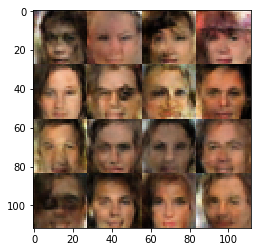

Epoch 1/1    Batch 10620... Discriminator Loss: 1.1217... Generator Loss: 1.0100
Epoch 1/1    Batch 10640... Discriminator Loss: 1.2652... Generator Loss: 0.9005
Epoch 1/1    Batch 10660... Discriminator Loss: 1.2521... Generator Loss: 0.9708
Epoch 1/1    Batch 10680... Discriminator Loss: 1.1895... Generator Loss: 0.9656
Epoch 1/1    Batch 10700... Discriminator Loss: 1.0230... Generator Loss: 1.3024


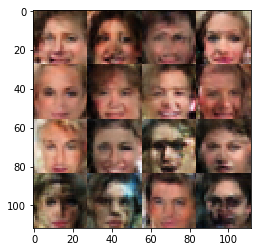

Epoch 1/1    Batch 10720... Discriminator Loss: 1.2157... Generator Loss: 0.9695
Epoch 1/1    Batch 10740... Discriminator Loss: 1.2227... Generator Loss: 0.9319
Epoch 1/1    Batch 10760... Discriminator Loss: 1.2443... Generator Loss: 1.2243
Epoch 1/1    Batch 10780... Discriminator Loss: 1.1991... Generator Loss: 1.1593
Epoch 1/1    Batch 10800... Discriminator Loss: 1.1290... Generator Loss: 0.9873


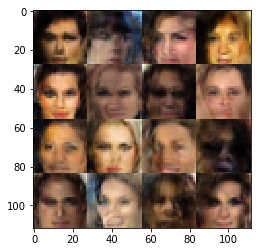

Epoch 1/1    Batch 10820... Discriminator Loss: 1.1742... Generator Loss: 0.9267
Epoch 1/1    Batch 10840... Discriminator Loss: 1.4647... Generator Loss: 1.0752
Epoch 1/1    Batch 10860... Discriminator Loss: 1.1064... Generator Loss: 0.9268
Epoch 1/1    Batch 10880... Discriminator Loss: 1.2551... Generator Loss: 1.0699
Epoch 1/1    Batch 10900... Discriminator Loss: 1.1033... Generator Loss: 1.1653


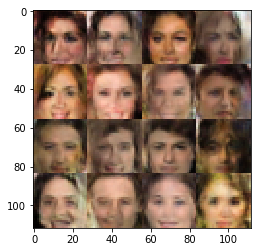

Epoch 1/1    Batch 10920... Discriminator Loss: 1.0858... Generator Loss: 1.1484
Epoch 1/1    Batch 10940... Discriminator Loss: 1.2413... Generator Loss: 0.8598
Epoch 1/1    Batch 10960... Discriminator Loss: 1.0968... Generator Loss: 1.0544
Epoch 1/1    Batch 10980... Discriminator Loss: 1.2668... Generator Loss: 1.1567
Epoch 1/1    Batch 11000... Discriminator Loss: 1.1013... Generator Loss: 0.8091


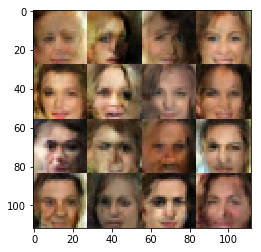

Epoch 1/1    Batch 11020... Discriminator Loss: 1.3154... Generator Loss: 1.0057
Epoch 1/1    Batch 11040... Discriminator Loss: 1.3198... Generator Loss: 1.1199
Epoch 1/1    Batch 11060... Discriminator Loss: 1.1413... Generator Loss: 1.0429
Epoch 1/1    Batch 11080... Discriminator Loss: 0.9745... Generator Loss: 1.4573
Epoch 1/1    Batch 11100... Discriminator Loss: 1.1403... Generator Loss: 1.0764


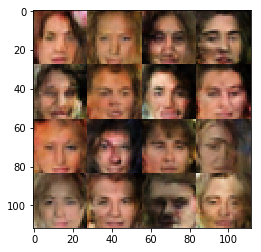

Epoch 1/1    Batch 11120... Discriminator Loss: 0.9827... Generator Loss: 0.9709
Epoch 1/1    Batch 11140... Discriminator Loss: 1.1526... Generator Loss: 1.1391
Epoch 1/1    Batch 11160... Discriminator Loss: 0.9976... Generator Loss: 1.1637
Epoch 1/1    Batch 11180... Discriminator Loss: 1.2319... Generator Loss: 1.2269
Epoch 1/1    Batch 11200... Discriminator Loss: 1.3169... Generator Loss: 1.0680


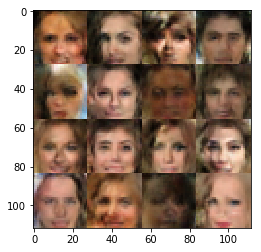

Epoch 1/1    Batch 11220... Discriminator Loss: 1.0100... Generator Loss: 1.2839
Epoch 1/1    Batch 11240... Discriminator Loss: 1.2065... Generator Loss: 1.1281
Epoch 1/1    Batch 11260... Discriminator Loss: 1.0396... Generator Loss: 1.2451
Epoch 1/1    Batch 11280... Discriminator Loss: 1.1393... Generator Loss: 0.9727
Epoch 1/1    Batch 11300... Discriminator Loss: 1.1702... Generator Loss: 1.1187


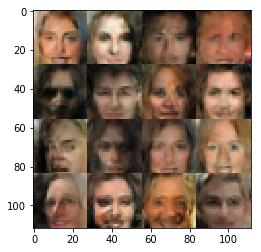

Epoch 1/1    Batch 11320... Discriminator Loss: 1.3559... Generator Loss: 1.0247
Epoch 1/1    Batch 11340... Discriminator Loss: 1.1437... Generator Loss: 1.1275
Epoch 1/1    Batch 11360... Discriminator Loss: 1.1706... Generator Loss: 0.8672
Epoch 1/1    Batch 11380... Discriminator Loss: 1.1226... Generator Loss: 0.9986
Epoch 1/1    Batch 11400... Discriminator Loss: 1.4157... Generator Loss: 0.6960


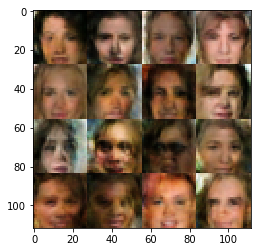

Epoch 1/1    Batch 11420... Discriminator Loss: 1.0759... Generator Loss: 1.1576
Epoch 1/1    Batch 11440... Discriminator Loss: 1.1519... Generator Loss: 0.8779
Epoch 1/1    Batch 11460... Discriminator Loss: 1.0557... Generator Loss: 1.2291
Epoch 1/1    Batch 11480... Discriminator Loss: 1.2773... Generator Loss: 0.9496
Epoch 1/1    Batch 11500... Discriminator Loss: 1.2797... Generator Loss: 0.9477


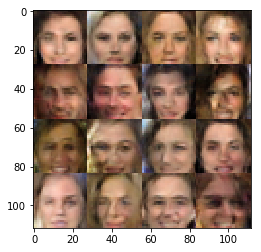

Epoch 1/1    Batch 11520... Discriminator Loss: 1.1809... Generator Loss: 1.3799
Epoch 1/1    Batch 11540... Discriminator Loss: 1.2475... Generator Loss: 0.9985
Epoch 1/1    Batch 11560... Discriminator Loss: 1.2346... Generator Loss: 0.9981
Epoch 1/1    Batch 11580... Discriminator Loss: 1.1283... Generator Loss: 1.2223
Epoch 1/1    Batch 11600... Discriminator Loss: 0.9420... Generator Loss: 1.2255


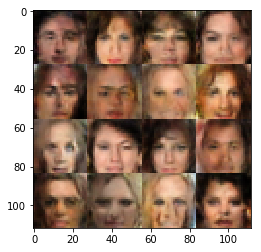

Epoch 1/1    Batch 11620... Discriminator Loss: 1.0805... Generator Loss: 1.3000
Epoch 1/1    Batch 11640... Discriminator Loss: 1.0969... Generator Loss: 1.0757
Epoch 1/1    Batch 11660... Discriminator Loss: 1.0312... Generator Loss: 1.4250
Epoch 1/1    Batch 11680... Discriminator Loss: 1.1189... Generator Loss: 1.2644
Epoch 1/1    Batch 11700... Discriminator Loss: 1.3248... Generator Loss: 0.8062


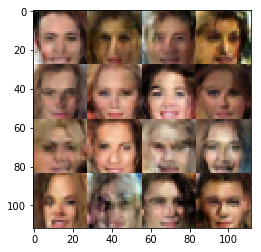

Epoch 1/1    Batch 11720... Discriminator Loss: 1.2671... Generator Loss: 0.9190
Epoch 1/1    Batch 11740... Discriminator Loss: 1.0847... Generator Loss: 1.0992
Epoch 1/1    Batch 11760... Discriminator Loss: 1.0142... Generator Loss: 1.1303
Epoch 1/1    Batch 11780... Discriminator Loss: 1.1741... Generator Loss: 0.9882
Epoch 1/1    Batch 11800... Discriminator Loss: 1.1301... Generator Loss: 1.2517


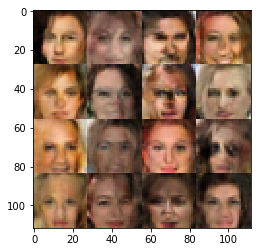

Epoch 1/1    Batch 11820... Discriminator Loss: 1.2287... Generator Loss: 1.0424
Epoch 1/1    Batch 11840... Discriminator Loss: 1.0003... Generator Loss: 0.9536
Epoch 1/1    Batch 11860... Discriminator Loss: 1.0662... Generator Loss: 0.8870
Epoch 1/1    Batch 11880... Discriminator Loss: 1.1532... Generator Loss: 1.1070
Epoch 1/1    Batch 11900... Discriminator Loss: 1.1771... Generator Loss: 1.2937


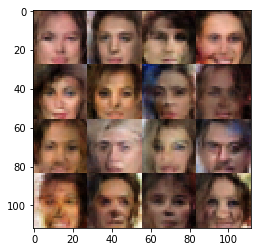

Epoch 1/1    Batch 11920... Discriminator Loss: 1.2457... Generator Loss: 1.0938
Epoch 1/1    Batch 11940... Discriminator Loss: 1.1143... Generator Loss: 1.3005
Epoch 1/1    Batch 11960... Discriminator Loss: 1.3035... Generator Loss: 0.9144
Epoch 1/1    Batch 11980... Discriminator Loss: 1.0713... Generator Loss: 0.9794
Epoch 1/1    Batch 12000... Discriminator Loss: 1.1231... Generator Loss: 1.0768


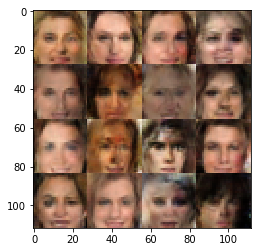

Epoch 1/1    Batch 12020... Discriminator Loss: 1.2863... Generator Loss: 1.0130
Epoch 1/1    Batch 12040... Discriminator Loss: 1.2417... Generator Loss: 0.8588
Epoch 1/1    Batch 12060... Discriminator Loss: 0.9184... Generator Loss: 1.1257
Epoch 1/1    Batch 12080... Discriminator Loss: 1.1917... Generator Loss: 1.0415
Epoch 1/1    Batch 12100... Discriminator Loss: 0.9406... Generator Loss: 1.4263


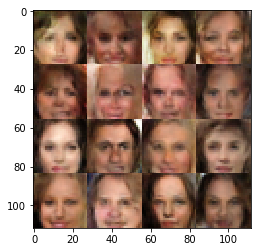

Epoch 1/1    Batch 12120... Discriminator Loss: 1.2193... Generator Loss: 1.0597
Epoch 1/1    Batch 12140... Discriminator Loss: 1.1546... Generator Loss: 1.2954
Epoch 1/1    Batch 12160... Discriminator Loss: 1.1619... Generator Loss: 0.9916
Epoch 1/1    Batch 12180... Discriminator Loss: 1.4385... Generator Loss: 0.9616
Epoch 1/1    Batch 12200... Discriminator Loss: 1.2803... Generator Loss: 1.3825


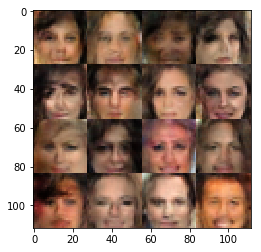

Epoch 1/1    Batch 12220... Discriminator Loss: 1.2956... Generator Loss: 1.2661
Epoch 1/1    Batch 12240... Discriminator Loss: 1.0905... Generator Loss: 1.0728
Epoch 1/1    Batch 12260... Discriminator Loss: 1.1192... Generator Loss: 1.0770
Epoch 1/1    Batch 12280... Discriminator Loss: 1.0452... Generator Loss: 1.1759
Epoch 1/1    Batch 12300... Discriminator Loss: 0.9697... Generator Loss: 1.4080


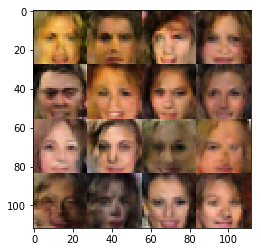

Epoch 1/1    Batch 12320... Discriminator Loss: 1.2648... Generator Loss: 0.8976
Epoch 1/1    Batch 12340... Discriminator Loss: 0.9875... Generator Loss: 1.1826
Epoch 1/1    Batch 12360... Discriminator Loss: 1.0829... Generator Loss: 0.9193
Epoch 1/1    Batch 12380... Discriminator Loss: 1.2354... Generator Loss: 1.0542
Epoch 1/1    Batch 12400... Discriminator Loss: 1.3587... Generator Loss: 1.1436


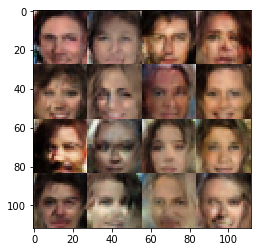

Epoch 1/1    Batch 12420... Discriminator Loss: 1.2879... Generator Loss: 0.8929
Epoch 1/1    Batch 12440... Discriminator Loss: 1.1194... Generator Loss: 1.0677
Epoch 1/1    Batch 12460... Discriminator Loss: 1.0207... Generator Loss: 1.1829
Epoch 1/1    Batch 12480... Discriminator Loss: 1.0650... Generator Loss: 0.9732
Epoch 1/1    Batch 12500... Discriminator Loss: 1.3838... Generator Loss: 1.1362


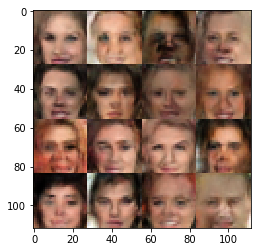

Epoch 1/1    Batch 12520... Discriminator Loss: 1.1015... Generator Loss: 1.1598
Epoch 1/1    Batch 12540... Discriminator Loss: 1.2280... Generator Loss: 1.1067
Epoch 1/1    Batch 12560... Discriminator Loss: 1.2634... Generator Loss: 1.1736
Epoch 1/1    Batch 12580... Discriminator Loss: 1.0175... Generator Loss: 1.1136
Epoch 1/1    Batch 12600... Discriminator Loss: 1.1901... Generator Loss: 1.2850


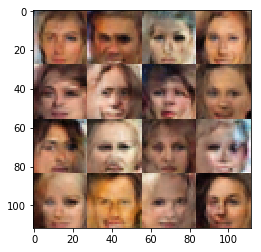

Epoch 1/1    Batch 12620... Discriminator Loss: 1.2607... Generator Loss: 0.8296
Epoch 1/1    Batch 12640... Discriminator Loss: 1.1232... Generator Loss: 1.0922
Epoch 1/1    Batch 12660... Discriminator Loss: 1.0698... Generator Loss: 1.4535


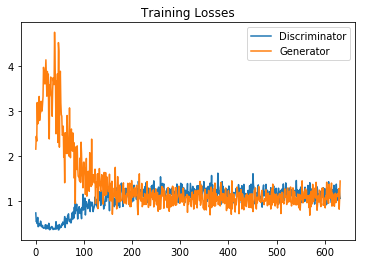

In [13]:
batch_size = 16
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.